In [31]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [3]:
# load text file 
def load_doc(filename):
	file = open(filename, 'r')
	# read text from file
	text = file.read()
	file.close()
	return text

filename = "C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [7]:
descriptions[ '1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [8]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [13]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [14]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [15]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [16]:
# Below path contains all the images
images = 'C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Flicker8k_Dataset\\'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [17]:
# Below file conatains the names of images to be used in train data
train_images_file = 'C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [18]:
# Below file conatains the names of images to be used in test data
test_images_file = 'C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [19]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the InceptionResNetV2  model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from InceptionResNetV2 model
    x = preprocess_input(x)
    return x

In [25]:
# Load the InceptionResNetV2 model
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

model = InceptionResNetV2(weights='imagenet')

225214464/225209952 [==============================] - 332s 1us/step


In [26]:
# Create a new model, by removing the last layer (output layer) from the InceptionResNetV2
model_new = Model(model.input, model.layers[-2].output)

In [27]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [28]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 5093.338946342468


In [33]:
# Save the bottleneck train features to disk
import _pickle as cPickle

with open("C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Pickle\\encoded_train_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_train, encoded_pickle)

In [34]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 882.497695684433


In [36]:
# Save the bottleneck test features to disk
with open("C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Pickle\\encoded_test_images.pkl", "wb") as encoded_pickle:
    cPickle.dump(encoding_test, encoded_pickle)

In [37]:
train_features = load(open("C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Pickle\\encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [38]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [39]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [40]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [41]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [42]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [43]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [45]:
#hereeeeee

In [47]:
!pip install bert-embedding

In [53]:
from bert_embedding import BertEmbedding

bert_embedding = BertEmbedding(model='bert_24_1024_16', dataset_name='book_corpus_wiki_en_cased',max_seq_length=200, )
# result = bert_embedding(sentences)

In [112]:
from flair.embeddings import BertEmbeddings,FlairEmbeddings,DocumentLSTMEmbeddings


In [61]:
bert_embeddings = BertEmbeddings('bert-base-uncased')

In [111]:
import torch
mylist = []
for key, desc_list in descriptions.items():
    for desc in desc_list:
        mysent = Sentence(desc, use_tokenizer=True)
        print(mysent)
        bert_embeddings.embed(mysent)
#         for token in mysent:
#             print(token.embedding)
        mylist.append(torch.cat([token.embedding.unsqueeze(0) for token in mysent], dim=0))
#             mylist.append(token.embedding)

Sentence: "child in pink dress is climbing up set of stairs in an entry way" - 14 Tokens
14
Sentence: "girl going into wooden building" - 5 Tokens
14
Sentence: "little girl climbing into wooden playhouse" - 6 Tokens
14
Sentence: "little girl climbing the stairs to her playhouse" - 8 Tokens
14
Sentence: "little girl in pink dress going into wooden cabin" - 9 Tokens
14
Sentence: "black dog and spotted dog are fighting" - 7 Tokens
14
Sentence: "black dog and tricolored dog playing with each other on the road" - 12 Tokens
14
Sentence: "black dog and white dog with brown spots are staring at each other in the street" - 16 Tokens
14
Sentence: "two dogs of different breeds looking at each other on the road" - 12 Tokens
14
Sentence: "two dogs on pavement moving toward each other" - 8 Tokens
14
Sentence: "little girl covered in paint sits in front of painted rainbow with her hands in bowl" - 16 Tokens
14
Sentence: "little girl is sitting in front of large painted rainbow" - 10 Tokens
14
Sentenc

KeyboardInterrupt: 

In [ ]:
mylist.shape

In [116]:
# Load Glove vectors
glove_dir = 'C:\\Users\\eenesmahm\\Downloads\\glove.6B'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


FLAIR Word Embedding Trial 

In [ ]:
# from flair.data import Sentence
# embedding_dim = 200

# # Get 200-dim dense vector for each of the 10000 words in out vocabulary
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# for word, i in wordtoix.items():
#     #if i < max_words
#     mysent = Sentence(word)
#     print(mysent)
#     bert_embeddings.embed(mysent)
#     print(mysent.embedding)
#     if embedding_vector is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix[i] = mysent.embedding

Glove Word Embeddings

In [118]:
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [119]:
embedding_matrix.shape

(1652, 300)

In [127]:
inputs1 = Input(shape=(1536,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [128]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 1536)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 34, 300)      495600      input_8[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1536)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dropout_6 

In [129]:
model.layers[2]

In [130]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [131]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [132]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [137]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('C:\\Users\\eenesmahm\\Documents\\model_weights\\model_' + str(i) + '.h5')

Epoch 1/1


 314/2000 [===>..........................] - ETA: 21:35 - loss: 3.15 - ETA: 18:50 - loss: 3.28 - ETA: 17:59 - loss: 3.14 - ETA: 16:47 - loss: 2.99 - ETA: 16:43 - loss: 2.97 - ETA: 16:22 - loss: 2.96 - ETA: 15:48 - loss: 2.97 - ETA: 16:06 - loss: 2.94 - ETA: 16:38 - loss: 2.98 - ETA: 16:51 - loss: 3.03 - ETA: 16:28 - loss: 3.06 - ETA: 16:16 - loss: 3.08 - ETA: 16:12 - loss: 3.07 - ETA: 16:05 - loss: 3.07 - ETA: 16:04 - loss: 3.05 - ETA: 15:54 - loss: 3.06 - ETA: 15:47 - loss: 3.07 - ETA: 15:41 - loss: 3.09 - ETA: 15:40 - loss: 3.07 - ETA: 15:37 - loss: 3.09 - ETA: 15:35 - loss: 3.11 - ETA: 15:50 - loss: 3.09 - ETA: 15:57 - loss: 3.07 - ETA: 16:00 - loss: 3.07 - ETA: 15:54 - loss: 3.08 - ETA: 15:53 - loss: 3.09 - ETA: 15:47 - loss: 3.11 - ETA: 15:42 - loss: 3.11 - ETA: 15:39 - loss: 3.10 - ETA: 15:32 - loss: 3.08 - ETA: 15:32 - loss: 3.05 - ETA: 15:38 - loss: 3.07 - ETA: 15:37 - loss: 3.07 - ETA: 15:40 - loss: 3.07 - ETA: 15:39 - loss: 3.09 - ETA: 15:36 - loss: 3.09 - ETA: 15:34 - loss: 

 628/2000 [========>.....................] - ETA: 14:43 - loss: 3.45 - ETA: 14:42 - loss: 3.44 - ETA: 14:41 - loss: 3.44 - ETA: 14:40 - loss: 3.44 - ETA: 14:39 - loss: 3.44 - ETA: 14:38 - loss: 3.44 - ETA: 14:37 - loss: 3.44 - ETA: 14:36 - loss: 3.44 - ETA: 14:35 - loss: 3.44 - ETA: 14:34 - loss: 3.44 - ETA: 14:34 - loss: 3.44 - ETA: 14:33 - loss: 3.44 - ETA: 14:32 - loss: 3.45 - ETA: 14:31 - loss: 3.45 - ETA: 14:30 - loss: 3.45 - ETA: 14:29 - loss: 3.45 - ETA: 14:28 - loss: 3.44 - ETA: 14:27 - loss: 3.44 - ETA: 14:26 - loss: 3.45 - ETA: 14:26 - loss: 3.44 - ETA: 14:25 - loss: 3.44 - ETA: 14:24 - loss: 3.44 - ETA: 14:24 - loss: 3.44 - ETA: 14:23 - loss: 3.44 - ETA: 14:22 - loss: 3.44 - ETA: 14:21 - loss: 3.44 - ETA: 14:19 - loss: 3.44 - ETA: 14:19 - loss: 3.44 - ETA: 14:18 - loss: 3.44 - ETA: 14:17 - loss: 3.44 - ETA: 14:16 - loss: 3.44 - ETA: 14:15 - loss: 3.44 - ETA: 14:14 - loss: 3.44 - ETA: 14:13 - loss: 3.44 - ETA: 14:12 - loss: 3.44 - ETA: 14:11 - loss: 3.44 - ETA: 14:10 - loss: 

 942/2000 [=============>................] - ETA: 11:29 - loss: 3.39 - ETA: 11:28 - loss: 3.39 - ETA: 11:27 - loss: 3.39 - ETA: 11:27 - loss: 3.39 - ETA: 11:26 - loss: 3.39 - ETA: 11:25 - loss: 3.39 - ETA: 11:24 - loss: 3.39 - ETA: 11:24 - loss: 3.39 - ETA: 11:23 - loss: 3.39 - ETA: 11:23 - loss: 3.39 - ETA: 11:22 - loss: 3.39 - ETA: 11:21 - loss: 3.39 - ETA: 11:20 - loss: 3.39 - ETA: 11:20 - loss: 3.39 - ETA: 11:19 - loss: 3.39 - ETA: 11:18 - loss: 3.39 - ETA: 11:18 - loss: 3.39 - ETA: 11:17 - loss: 3.38 - ETA: 11:16 - loss: 3.38 - ETA: 11:16 - loss: 3.38 - ETA: 11:15 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:14 - loss: 3.38 - ETA: 11:13 - loss: 3.38 - ETA: 11:12 - loss: 3.39 - ETA: 11:12 - loss: 3.39 - ETA: 11:11 - loss: 3.39 - ETA: 11:10 - loss: 3.38 - ETA: 11:09 - loss: 3.38 - ETA: 11:09 - loss: 3.39 - ETA: 11:08 - loss: 3.39 - ETA: 11:07 - loss: 3.39 - ETA: 11:07 - loss: 3.39 - ETA: 11:06 - loss: 3.39 - ETA: 11:06 - loss: 3.39 - ETA: 11:05 - loss: 3.39 - ETA: 11:05 - loss: 

1256/2000 [=================>............] - ETA: 8:34 - loss: 3.374 - ETA: 8:34 - loss: 3.374 - ETA: 8:33 - loss: 3.374 - ETA: 8:33 - loss: 3.374 - ETA: 8:32 - loss: 3.374 - ETA: 8:32 - loss: 3.374 - ETA: 8:31 - loss: 3.374 - ETA: 8:31 - loss: 3.375 - ETA: 8:30 - loss: 3.375 - ETA: 8:30 - loss: 3.376 - ETA: 8:29 - loss: 3.376 - ETA: 8:29 - loss: 3.377 - ETA: 8:28 - loss: 3.377 - ETA: 8:28 - loss: 3.377 - ETA: 8:27 - loss: 3.377 - ETA: 8:27 - loss: 3.377 - ETA: 8:26 - loss: 3.378 - ETA: 8:26 - loss: 3.378 - ETA: 8:25 - loss: 3.377 - ETA: 8:25 - loss: 3.377 - ETA: 8:24 - loss: 3.377 - ETA: 8:24 - loss: 3.377 - ETA: 8:24 - loss: 3.377 - ETA: 8:23 - loss: 3.377 - ETA: 8:23 - loss: 3.376 - ETA: 8:22 - loss: 3.376 - ETA: 8:22 - loss: 3.376 - ETA: 8:21 - loss: 3.376 - ETA: 8:21 - loss: 3.376 - ETA: 8:20 - loss: 3.376 - ETA: 8:20 - loss: 3.376 - ETA: 8:20 - loss: 3.376 - ETA: 8:19 - loss: 3.376 - ETA: 8:19 - loss: 3.376 - ETA: 8:18 - loss: 3.376 - ETA: 8:18 - loss: 3.376 - ETA: 8:17 - loss: 3

1570/2000 [======================>.......] - ETA: 5:56 - loss: 3.370 - ETA: 5:56 - loss: 3.369 - ETA: 5:55 - loss: 3.369 - ETA: 5:55 - loss: 3.369 - ETA: 5:54 - loss: 3.369 - ETA: 5:54 - loss: 3.369 - ETA: 5:53 - loss: 3.369 - ETA: 5:53 - loss: 3.368 - ETA: 5:52 - loss: 3.368 - ETA: 5:52 - loss: 3.368 - ETA: 5:51 - loss: 3.368 - ETA: 5:51 - loss: 3.367 - ETA: 5:50 - loss: 3.367 - ETA: 5:50 - loss: 3.367 - ETA: 5:49 - loss: 3.367 - ETA: 5:48 - loss: 3.367 - ETA: 5:48 - loss: 3.367 - ETA: 5:47 - loss: 3.367 - ETA: 5:47 - loss: 3.366 - ETA: 5:46 - loss: 3.366 - ETA: 5:46 - loss: 3.367 - ETA: 5:45 - loss: 3.366 - ETA: 5:45 - loss: 3.366 - ETA: 5:44 - loss: 3.366 - ETA: 5:44 - loss: 3.366 - ETA: 5:43 - loss: 3.366 - ETA: 5:43 - loss: 3.367 - ETA: 5:42 - loss: 3.367 - ETA: 5:42 - loss: 3.367 - ETA: 5:41 - loss: 3.366 - ETA: 5:41 - loss: 3.367 - ETA: 5:40 - loss: 3.367 - ETA: 5:40 - loss: 3.367 - ETA: 5:39 - loss: 3.367 - ETA: 5:39 - loss: 3.367 - ETA: 5:38 - loss: 3.367 - ETA: 5:38 - loss: 3

1884/2000 [===========================>..] - ETA: 3:26 - loss: 3.353 - ETA: 3:26 - loss: 3.352 - ETA: 3:25 - loss: 3.352 - ETA: 3:25 - loss: 3.353 - ETA: 3:24 - loss: 3.353 - ETA: 3:24 - loss: 3.353 - ETA: 3:23 - loss: 3.353 - ETA: 3:23 - loss: 3.353 - ETA: 3:22 - loss: 3.353 - ETA: 3:22 - loss: 3.353 - ETA: 3:21 - loss: 3.353 - ETA: 3:21 - loss: 3.353 - ETA: 3:21 - loss: 3.353 - ETA: 3:20 - loss: 3.353 - ETA: 3:20 - loss: 3.353 - ETA: 3:19 - loss: 3.353 - ETA: 3:19 - loss: 3.353 - ETA: 3:18 - loss: 3.353 - ETA: 3:18 - loss: 3.353 - ETA: 3:17 - loss: 3.353 - ETA: 3:17 - loss: 3.353 - ETA: 3:16 - loss: 3.353 - ETA: 3:16 - loss: 3.353 - ETA: 3:15 - loss: 3.352 - ETA: 3:15 - loss: 3.352 - ETA: 3:14 - loss: 3.352 - ETA: 3:14 - loss: 3.352 - ETA: 3:14 - loss: 3.353 - ETA: 3:13 - loss: 3.353 - ETA: 3:13 - loss: 3.353 - ETA: 3:12 - loss: 3.353 - ETA: 3:12 - loss: 3.353 - ETA: 3:11 - loss: 3.353 - ETA: 3:11 - loss: 3.353 - ETA: 3:10 - loss: 3.352 - ETA: 3:10 - loss: 3.352 - ETA: 3:09 - loss: 3

2000/2000 [==============================] - ETA: 57s - loss: 3.34 - ETA: 56s - loss: 3.34 - ETA: 56s - loss: 3.34 - ETA: 55s - loss: 3.34 - ETA: 55s - loss: 3.34 - ETA: 54s - loss: 3.34 - ETA: 54s - loss: 3.34 - ETA: 53s - loss: 3.34 - ETA: 53s - loss: 3.34 - ETA: 52s - loss: 3.34 - ETA: 52s - loss: 3.34 - ETA: 51s - loss: 3.34 - ETA: 51s - loss: 3.34 - ETA: 50s - loss: 3.34 - ETA: 50s - loss: 3.34 - ETA: 49s - loss: 3.34 - ETA: 49s - loss: 3.34 - ETA: 48s - loss: 3.34 - ETA: 48s - loss: 3.34 - ETA: 47s - loss: 3.34 - ETA: 47s - loss: 3.34 - ETA: 46s - loss: 3.34 - ETA: 46s - loss: 3.34 - ETA: 45s - loss: 3.34 - ETA: 45s - loss: 3.34 - ETA: 44s - loss: 3.34 - ETA: 44s - loss: 3.34 - ETA: 43s - loss: 3.34 - ETA: 43s - loss: 3.34 - ETA: 42s - loss: 3.34 - ETA: 42s - loss: 3.34 - ETA: 41s - loss: 3.34 - ETA: 41s - loss: 3.34 - ETA: 40s - loss: 3.34 - ETA: 40s - loss: 3.33 - ETA: 39s - loss: 3.33 - ETA: 39s - loss: 3.33 - ETA: 38s - loss: 3.33 - ETA: 38s - loss: 3.33 - ETA: 37s - loss: 3.

 314/2000 [===>..........................] - ETA: 21:14 - loss: 3.15 - ETA: 18:19 - loss: 3.18 - ETA: 19:46 - loss: 3.07 - ETA: 19:49 - loss: 2.93 - ETA: 19:45 - loss: 2.91 - ETA: 19:38 - loss: 2.91 - ETA: 20:09 - loss: 2.95 - ETA: 20:17 - loss: 2.89 - ETA: 20:21 - loss: 2.94 - ETA: 20:12 - loss: 2.98 - ETA: 19:44 - loss: 3.00 - ETA: 19:25 - loss: 3.03 - ETA: 19:40 - loss: 3.02 - ETA: 19:34 - loss: 3.02 - ETA: 19:20 - loss: 3.00 - ETA: 18:59 - loss: 3.01 - ETA: 18:45 - loss: 3.02 - ETA: 18:31 - loss: 3.04 - ETA: 18:19 - loss: 3.02 - ETA: 18:10 - loss: 3.04 - ETA: 17:57 - loss: 3.05 - ETA: 17:46 - loss: 3.04 - ETA: 17:40 - loss: 3.02 - ETA: 17:30 - loss: 3.01 - ETA: 17:34 - loss: 3.02 - ETA: 17:37 - loss: 3.03 - ETA: 17:38 - loss: 3.06 - ETA: 17:36 - loss: 3.05 - ETA: 17:29 - loss: 3.04 - ETA: 17:28 - loss: 3.03 - ETA: 17:29 - loss: 3.00 - ETA: 17:34 - loss: 3.01 - ETA: 17:44 - loss: 3.01 - ETA: 17:59 - loss: 3.02 - ETA: 18:14 - loss: 3.04 - ETA: 18:13 - loss: 3.03 - ETA: 18:12 - loss: 

 628/2000 [========>.....................] - ETA: 15:59 - loss: 3.20 - ETA: 15:58 - loss: 3.20 - ETA: 15:57 - loss: 3.20 - ETA: 15:55 - loss: 3.19 - ETA: 15:54 - loss: 3.19 - ETA: 15:53 - loss: 3.19 - ETA: 15:52 - loss: 3.19 - ETA: 15:51 - loss: 3.19 - ETA: 15:50 - loss: 3.19 - ETA: 15:49 - loss: 3.20 - ETA: 15:48 - loss: 3.20 - ETA: 15:47 - loss: 3.20 - ETA: 15:45 - loss: 3.20 - ETA: 15:44 - loss: 3.20 - ETA: 15:43 - loss: 3.20 - ETA: 15:42 - loss: 3.20 - ETA: 15:41 - loss: 3.20 - ETA: 15:40 - loss: 3.20 - ETA: 15:38 - loss: 3.20 - ETA: 15:37 - loss: 3.20 - ETA: 15:36 - loss: 3.20 - ETA: 15:35 - loss: 3.20 - ETA: 15:34 - loss: 3.20 - ETA: 15:33 - loss: 3.19 - ETA: 15:32 - loss: 3.19 - ETA: 15:31 - loss: 3.19 - ETA: 15:30 - loss: 3.20 - ETA: 15:29 - loss: 3.20 - ETA: 15:28 - loss: 3.20 - ETA: 15:27 - loss: 3.20 - ETA: 15:26 - loss: 3.20 - ETA: 15:25 - loss: 3.19 - ETA: 15:25 - loss: 3.19 - ETA: 15:26 - loss: 3.19 - ETA: 15:26 - loss: 3.19 - ETA: 15:25 - loss: 3.19 - ETA: 15:25 - loss: 

 942/2000 [=============>................] - ETA: 11:59 - loss: 3.14 - ETA: 11:58 - loss: 3.14 - ETA: 11:58 - loss: 3.14 - ETA: 11:57 - loss: 3.14 - ETA: 11:56 - loss: 3.14 - ETA: 11:55 - loss: 3.14 - ETA: 11:55 - loss: 3.14 - ETA: 11:55 - loss: 3.14 - ETA: 11:54 - loss: 3.14 - ETA: 11:53 - loss: 3.14 - ETA: 11:53 - loss: 3.14 - ETA: 11:53 - loss: 3.14 - ETA: 11:52 - loss: 3.14 - ETA: 11:51 - loss: 3.14 - ETA: 11:50 - loss: 3.14 - ETA: 11:50 - loss: 3.14 - ETA: 11:49 - loss: 3.14 - ETA: 11:49 - loss: 3.14 - ETA: 11:49 - loss: 3.14 - ETA: 11:48 - loss: 3.14 - ETA: 11:48 - loss: 3.14 - ETA: 11:47 - loss: 3.14 - ETA: 11:46 - loss: 3.14 - ETA: 11:46 - loss: 3.14 - ETA: 11:45 - loss: 3.14 - ETA: 11:44 - loss: 3.14 - ETA: 11:44 - loss: 3.14 - ETA: 11:43 - loss: 3.14 - ETA: 11:43 - loss: 3.14 - ETA: 11:42 - loss: 3.14 - ETA: 11:41 - loss: 3.14 - ETA: 11:41 - loss: 3.14 - ETA: 11:40 - loss: 3.14 - ETA: 11:39 - loss: 3.14 - ETA: 11:39 - loss: 3.14 - ETA: 11:38 - loss: 3.14 - ETA: 11:37 - loss: 

1256/2000 [=================>............] - ETA: 9:00 - loss: 3.136 - ETA: 9:00 - loss: 3.136 - ETA: 8:59 - loss: 3.136 - ETA: 8:59 - loss: 3.136 - ETA: 8:58 - loss: 3.136 - ETA: 8:58 - loss: 3.136 - ETA: 8:57 - loss: 3.136 - ETA: 8:57 - loss: 3.137 - ETA: 8:56 - loss: 3.137 - ETA: 8:56 - loss: 3.138 - ETA: 8:55 - loss: 3.138 - ETA: 8:54 - loss: 3.139 - ETA: 8:54 - loss: 3.139 - ETA: 8:53 - loss: 3.139 - ETA: 8:53 - loss: 3.139 - ETA: 8:52 - loss: 3.139 - ETA: 8:52 - loss: 3.140 - ETA: 8:51 - loss: 3.140 - ETA: 8:51 - loss: 3.139 - ETA: 8:50 - loss: 3.139 - ETA: 8:50 - loss: 3.139 - ETA: 8:50 - loss: 3.139 - ETA: 8:49 - loss: 3.139 - ETA: 8:49 - loss: 3.139 - ETA: 8:48 - loss: 3.139 - ETA: 8:48 - loss: 3.139 - ETA: 8:47 - loss: 3.138 - ETA: 8:47 - loss: 3.138 - ETA: 8:46 - loss: 3.138 - ETA: 8:46 - loss: 3.138 - ETA: 8:46 - loss: 3.139 - ETA: 8:45 - loss: 3.139 - ETA: 8:45 - loss: 3.139 - ETA: 8:45 - loss: 3.139 - ETA: 8:45 - loss: 3.139 - ETA: 8:44 - loss: 3.138 - ETA: 8:44 - loss: 3

1570/2000 [======================>.......] - ETA: 6:27 - loss: 3.139 - ETA: 6:26 - loss: 3.139 - ETA: 6:26 - loss: 3.139 - ETA: 6:25 - loss: 3.139 - ETA: 6:25 - loss: 3.139 - ETA: 6:24 - loss: 3.138 - ETA: 6:23 - loss: 3.139 - ETA: 6:23 - loss: 3.138 - ETA: 6:22 - loss: 3.138 - ETA: 6:22 - loss: 3.138 - ETA: 6:21 - loss: 3.138 - ETA: 6:21 - loss: 3.137 - ETA: 6:20 - loss: 3.137 - ETA: 6:20 - loss: 3.137 - ETA: 6:19 - loss: 3.137 - ETA: 6:18 - loss: 3.137 - ETA: 6:18 - loss: 3.137 - ETA: 6:17 - loss: 3.137 - ETA: 6:17 - loss: 3.136 - ETA: 6:16 - loss: 3.136 - ETA: 6:16 - loss: 3.137 - ETA: 6:15 - loss: 3.136 - ETA: 6:15 - loss: 3.136 - ETA: 6:14 - loss: 3.136 - ETA: 6:14 - loss: 3.136 - ETA: 6:13 - loss: 3.137 - ETA: 6:13 - loss: 3.137 - ETA: 6:12 - loss: 3.137 - ETA: 6:12 - loss: 3.137 - ETA: 6:11 - loss: 3.137 - ETA: 6:10 - loss: 3.137 - ETA: 6:10 - loss: 3.137 - ETA: 6:09 - loss: 3.137 - ETA: 6:09 - loss: 3.138 - ETA: 6:08 - loss: 3.138 - ETA: 6:08 - loss: 3.137 - ETA: 6:07 - loss: 3

1884/2000 [===========================>..] - ETA: 3:42 - loss: 3.131 - ETA: 3:41 - loss: 3.131 - ETA: 3:41 - loss: 3.131 - ETA: 3:40 - loss: 3.131 - ETA: 3:40 - loss: 3.131 - ETA: 3:39 - loss: 3.132 - ETA: 3:39 - loss: 3.132 - ETA: 3:38 - loss: 3.132 - ETA: 3:38 - loss: 3.132 - ETA: 3:37 - loss: 3.131 - ETA: 3:37 - loss: 3.132 - ETA: 3:36 - loss: 3.132 - ETA: 3:36 - loss: 3.132 - ETA: 3:35 - loss: 3.132 - ETA: 3:34 - loss: 3.132 - ETA: 3:34 - loss: 3.132 - ETA: 3:33 - loss: 3.132 - ETA: 3:33 - loss: 3.132 - ETA: 3:32 - loss: 3.132 - ETA: 3:32 - loss: 3.132 - ETA: 3:31 - loss: 3.132 - ETA: 3:31 - loss: 3.132 - ETA: 3:30 - loss: 3.132 - ETA: 3:30 - loss: 3.131 - ETA: 3:29 - loss: 3.131 - ETA: 3:29 - loss: 3.131 - ETA: 3:28 - loss: 3.131 - ETA: 3:28 - loss: 3.132 - ETA: 3:27 - loss: 3.132 - ETA: 3:26 - loss: 3.132 - ETA: 3:26 - loss: 3.132 - ETA: 3:26 - loss: 3.132 - ETA: 3:25 - loss: 3.132 - ETA: 3:24 - loss: 3.132 - ETA: 3:24 - loss: 3.132 - ETA: 3:23 - loss: 3.132 - ETA: 3:23 - loss: 3

2000/2000 [==============================] - ETA: 59s - loss: 3.12 - ETA: 58s - loss: 3.12 - ETA: 58s - loss: 3.12 - ETA: 57s - loss: 3.12 - ETA: 57s - loss: 3.12 - ETA: 56s - loss: 3.12 - ETA: 56s - loss: 3.12 - ETA: 55s - loss: 3.12 - ETA: 55s - loss: 3.12 - ETA: 54s - loss: 3.12 - ETA: 54s - loss: 3.12 - ETA: 53s - loss: 3.12 - ETA: 53s - loss: 3.12 - ETA: 52s - loss: 3.12 - ETA: 52s - loss: 3.12 - ETA: 51s - loss: 3.12 - ETA: 51s - loss: 3.12 - ETA: 50s - loss: 3.12 - ETA: 50s - loss: 3.12 - ETA: 49s - loss: 3.12 - ETA: 49s - loss: 3.12 - ETA: 48s - loss: 3.12 - ETA: 48s - loss: 3.12 - ETA: 47s - loss: 3.12 - ETA: 47s - loss: 3.12 - ETA: 46s - loss: 3.12 - ETA: 46s - loss: 3.12 - ETA: 45s - loss: 3.12 - ETA: 44s - loss: 3.12 - ETA: 44s - loss: 3.12 - ETA: 43s - loss: 3.12 - ETA: 43s - loss: 3.12 - ETA: 42s - loss: 3.12 - ETA: 42s - loss: 3.12 - ETA: 41s - loss: 3.12 - ETA: 41s - loss: 3.12 - ETA: 40s - loss: 3.12 - ETA: 40s - loss: 3.12 - ETA: 39s - loss: 3.12 - ETA: 39s - loss: 3.

 314/2000 [===>..........................] - ETA: 24:22 - loss: 3.07 - ETA: 20:56 - loss: 3.08 - ETA: 20:51 - loss: 2.95 - ETA: 21:53 - loss: 2.80 - ETA: 21:25 - loss: 2.80 - ETA: 20:55 - loss: 2.80 - ETA: 20:01 - loss: 2.83 - ETA: 19:43 - loss: 2.77 - ETA: 19:50 - loss: 2.83 - ETA: 19:31 - loss: 2.88 - ETA: 19:33 - loss: 2.89 - ETA: 20:01 - loss: 2.91 - ETA: 20:06 - loss: 2.90 - ETA: 19:50 - loss: 2.90 - ETA: 19:47 - loss: 2.88 - ETA: 19:42 - loss: 2.88 - ETA: 19:35 - loss: 2.89 - ETA: 19:24 - loss: 2.91 - ETA: 19:09 - loss: 2.89 - ETA: 19:07 - loss: 2.90 - ETA: 19:01 - loss: 2.92 - ETA: 18:52 - loss: 2.91 - ETA: 18:49 - loss: 2.89 - ETA: 18:49 - loss: 2.88 - ETA: 18:43 - loss: 2.89 - ETA: 18:38 - loss: 2.90 - ETA: 18:30 - loss: 2.92 - ETA: 18:43 - loss: 2.91 - ETA: 18:43 - loss: 2.90 - ETA: 18:39 - loss: 2.89 - ETA: 18:34 - loss: 2.86 - ETA: 18:37 - loss: 2.88 - ETA: 18:37 - loss: 2.89 - ETA: 18:42 - loss: 2.89 - ETA: 18:39 - loss: 2.91 - ETA: 18:34 - loss: 2.90 - ETA: 18:31 - loss: 

 628/2000 [========>.....................] - ETA: 15:20 - loss: 3.05 - ETA: 15:19 - loss: 3.05 - ETA: 15:19 - loss: 3.05 - ETA: 15:18 - loss: 3.04 - ETA: 15:17 - loss: 3.04 - ETA: 15:17 - loss: 3.04 - ETA: 15:16 - loss: 3.04 - ETA: 15:16 - loss: 3.05 - ETA: 15:15 - loss: 3.05 - ETA: 15:14 - loss: 3.05 - ETA: 15:13 - loss: 3.05 - ETA: 15:13 - loss: 3.05 - ETA: 15:12 - loss: 3.05 - ETA: 15:11 - loss: 3.05 - ETA: 15:10 - loss: 3.05 - ETA: 15:10 - loss: 3.05 - ETA: 15:09 - loss: 3.05 - ETA: 15:08 - loss: 3.05 - ETA: 15:07 - loss: 3.05 - ETA: 15:07 - loss: 3.05 - ETA: 15:07 - loss: 3.05 - ETA: 15:06 - loss: 3.05 - ETA: 15:06 - loss: 3.05 - ETA: 15:05 - loss: 3.04 - ETA: 15:04 - loss: 3.05 - ETA: 15:03 - loss: 3.04 - ETA: 15:02 - loss: 3.05 - ETA: 15:01 - loss: 3.05 - ETA: 15:00 - loss: 3.05 - ETA: 14:59 - loss: 3.05 - ETA: 14:59 - loss: 3.05 - ETA: 14:57 - loss: 3.04 - ETA: 14:57 - loss: 3.04 - ETA: 14:56 - loss: 3.04 - ETA: 14:57 - loss: 3.04 - ETA: 14:56 - loss: 3.04 - ETA: 14:56 - loss: 

 942/2000 [=============>................] - ETA: 12:39 - loss: 3.00 - ETA: 12:38 - loss: 3.00 - ETA: 12:37 - loss: 3.00 - ETA: 12:37 - loss: 3.00 - ETA: 12:36 - loss: 3.00 - ETA: 12:35 - loss: 3.00 - ETA: 12:35 - loss: 3.00 - ETA: 12:34 - loss: 3.00 - ETA: 12:33 - loss: 3.00 - ETA: 12:33 - loss: 3.00 - ETA: 12:32 - loss: 3.00 - ETA: 12:31 - loss: 3.00 - ETA: 12:31 - loss: 3.00 - ETA: 12:30 - loss: 3.00 - ETA: 12:29 - loss: 3.00 - ETA: 12:28 - loss: 3.00 - ETA: 12:28 - loss: 3.00 - ETA: 12:27 - loss: 3.00 - ETA: 12:26 - loss: 3.00 - ETA: 12:25 - loss: 3.00 - ETA: 12:25 - loss: 3.00 - ETA: 12:24 - loss: 3.00 - ETA: 12:24 - loss: 3.00 - ETA: 12:24 - loss: 3.00 - ETA: 12:23 - loss: 3.00 - ETA: 12:22 - loss: 3.00 - ETA: 12:21 - loss: 3.00 - ETA: 12:21 - loss: 3.00 - ETA: 12:20 - loss: 3.00 - ETA: 12:19 - loss: 3.00 - ETA: 12:18 - loss: 3.00 - ETA: 12:17 - loss: 3.00 - ETA: 12:17 - loss: 3.00 - ETA: 12:16 - loss: 3.00 - ETA: 12:15 - loss: 3.00 - ETA: 12:15 - loss: 3.00 - ETA: 12:14 - loss: 

1256/2000 [=================>............] - ETA: 9:32 - loss: 2.996 - ETA: 9:31 - loss: 2.996 - ETA: 9:31 - loss: 2.996 - ETA: 9:30 - loss: 2.996 - ETA: 9:29 - loss: 2.997 - ETA: 9:29 - loss: 2.997 - ETA: 9:28 - loss: 2.997 - ETA: 9:28 - loss: 2.997 - ETA: 9:27 - loss: 2.998 - ETA: 9:26 - loss: 2.999 - ETA: 9:26 - loss: 2.999 - ETA: 9:25 - loss: 2.999 - ETA: 9:25 - loss: 2.999 - ETA: 9:24 - loss: 2.999 - ETA: 9:24 - loss: 2.999 - ETA: 9:24 - loss: 3.000 - ETA: 9:24 - loss: 3.000 - ETA: 9:24 - loss: 3.000 - ETA: 9:23 - loss: 3.000 - ETA: 9:22 - loss: 3.000 - ETA: 9:22 - loss: 3.000 - ETA: 9:21 - loss: 3.000 - ETA: 9:21 - loss: 3.000 - ETA: 9:20 - loss: 2.999 - ETA: 9:20 - loss: 2.999 - ETA: 9:19 - loss: 2.999 - ETA: 9:19 - loss: 2.999 - ETA: 9:18 - loss: 2.999 - ETA: 9:18 - loss: 2.999 - ETA: 9:17 - loss: 2.999 - ETA: 9:16 - loss: 2.999 - ETA: 9:16 - loss: 2.999 - ETA: 9:15 - loss: 2.999 - ETA: 9:15 - loss: 2.999 - ETA: 9:14 - loss: 2.999 - ETA: 9:14 - loss: 2.999 - ETA: 9:13 - loss: 2

1570/2000 [======================>.......] - ETA: 6:46 - loss: 3.002 - ETA: 6:45 - loss: 3.002 - ETA: 6:45 - loss: 3.001 - ETA: 6:44 - loss: 3.001 - ETA: 6:43 - loss: 3.001 - ETA: 6:43 - loss: 3.001 - ETA: 6:42 - loss: 3.001 - ETA: 6:42 - loss: 3.001 - ETA: 6:41 - loss: 3.001 - ETA: 6:41 - loss: 3.000 - ETA: 6:40 - loss: 3.000 - ETA: 6:40 - loss: 3.000 - ETA: 6:39 - loss: 3.000 - ETA: 6:38 - loss: 3.000 - ETA: 6:38 - loss: 3.000 - ETA: 6:37 - loss: 3.000 - ETA: 6:37 - loss: 3.000 - ETA: 6:36 - loss: 3.000 - ETA: 6:36 - loss: 2.999 - ETA: 6:35 - loss: 2.999 - ETA: 6:35 - loss: 3.000 - ETA: 6:34 - loss: 2.999 - ETA: 6:34 - loss: 2.999 - ETA: 6:33 - loss: 2.999 - ETA: 6:32 - loss: 2.999 - ETA: 6:32 - loss: 2.999 - ETA: 6:31 - loss: 3.000 - ETA: 6:31 - loss: 3.000 - ETA: 6:30 - loss: 3.000 - ETA: 6:30 - loss: 3.000 - ETA: 6:29 - loss: 3.000 - ETA: 6:29 - loss: 3.000 - ETA: 6:28 - loss: 3.000 - ETA: 6:28 - loss: 3.000 - ETA: 6:27 - loss: 3.000 - ETA: 6:27 - loss: 3.000 - ETA: 6:26 - loss: 3

1884/2000 [===========================>..] - ETA: 3:48 - loss: 2.996 - ETA: 3:47 - loss: 2.996 - ETA: 3:46 - loss: 2.995 - ETA: 3:46 - loss: 2.996 - ETA: 3:45 - loss: 2.996 - ETA: 3:45 - loss: 2.996 - ETA: 3:44 - loss: 2.996 - ETA: 3:44 - loss: 2.996 - ETA: 3:43 - loss: 2.997 - ETA: 3:43 - loss: 2.996 - ETA: 3:42 - loss: 2.996 - ETA: 3:41 - loss: 2.997 - ETA: 3:41 - loss: 2.997 - ETA: 3:40 - loss: 2.997 - ETA: 3:40 - loss: 2.997 - ETA: 3:39 - loss: 2.997 - ETA: 3:39 - loss: 2.997 - ETA: 3:38 - loss: 2.997 - ETA: 3:37 - loss: 2.997 - ETA: 3:37 - loss: 2.997 - ETA: 3:36 - loss: 2.997 - ETA: 3:36 - loss: 2.997 - ETA: 3:35 - loss: 2.997 - ETA: 3:35 - loss: 2.996 - ETA: 3:34 - loss: 2.997 - ETA: 3:33 - loss: 2.996 - ETA: 3:33 - loss: 2.996 - ETA: 3:32 - loss: 2.997 - ETA: 3:32 - loss: 2.997 - ETA: 3:31 - loss: 2.997 - ETA: 3:31 - loss: 2.998 - ETA: 3:30 - loss: 2.997 - ETA: 3:30 - loss: 2.997 - ETA: 3:29 - loss: 2.997 - ETA: 3:28 - loss: 2.997 - ETA: 3:28 - loss: 2.997 - ETA: 3:27 - loss: 2

2000/2000 [==============================] - ETA: 58s - loss: 2.99 - ETA: 58s - loss: 2.99 - ETA: 57s - loss: 2.99 - ETA: 57s - loss: 2.99 - ETA: 56s - loss: 2.99 - ETA: 56s - loss: 2.99 - ETA: 55s - loss: 2.99 - ETA: 54s - loss: 2.99 - ETA: 54s - loss: 2.99 - ETA: 53s - loss: 2.99 - ETA: 53s - loss: 2.99 - ETA: 52s - loss: 2.99 - ETA: 52s - loss: 2.99 - ETA: 51s - loss: 2.99 - ETA: 51s - loss: 2.99 - ETA: 50s - loss: 2.99 - ETA: 50s - loss: 2.99 - ETA: 49s - loss: 2.99 - ETA: 49s - loss: 2.99 - ETA: 48s - loss: 2.99 - ETA: 48s - loss: 2.99 - ETA: 47s - loss: 2.99 - ETA: 47s - loss: 2.99 - ETA: 46s - loss: 2.99 - ETA: 46s - loss: 2.99 - ETA: 45s - loss: 2.99 - ETA: 45s - loss: 2.99 - ETA: 44s - loss: 2.99 - ETA: 44s - loss: 2.99 - ETA: 43s - loss: 2.99 - ETA: 43s - loss: 2.99 - ETA: 42s - loss: 2.99 - ETA: 42s - loss: 2.99 - ETA: 41s - loss: 2.99 - ETA: 41s - loss: 2.99 - ETA: 40s - loss: 2.99 - ETA: 40s - loss: 2.99 - ETA: 39s - loss: 2.99 - ETA: 39s - loss: 2.99 - ETA: 38s - loss: 2.

 314/2000 [===>..........................] - ETA: 16:01 - loss: 3.06 - ETA: 14:30 - loss: 3.02 - ETA: 14:31 - loss: 2.89 - ETA: 14:25 - loss: 2.73 - ETA: 14:14 - loss: 2.74 - ETA: 14:01 - loss: 2.74 - ETA: 13:42 - loss: 2.77 - ETA: 13:40 - loss: 2.71 - ETA: 13:49 - loss: 2.76 - ETA: 13:47 - loss: 2.80 - ETA: 13:38 - loss: 2.82 - ETA: 13:29 - loss: 2.82 - ETA: 13:23 - loss: 2.82 - ETA: 13:21 - loss: 2.81 - ETA: 13:21 - loss: 2.80 - ETA: 13:19 - loss: 2.80 - ETA: 13:32 - loss: 2.80 - ETA: 13:37 - loss: 2.82 - ETA: 13:41 - loss: 2.80 - ETA: 13:40 - loss: 2.82 - ETA: 13:35 - loss: 2.83 - ETA: 13:30 - loss: 2.82 - ETA: 13:28 - loss: 2.80 - ETA: 13:25 - loss: 2.79 - ETA: 13:20 - loss: 2.80 - ETA: 13:16 - loss: 2.80 - ETA: 13:12 - loss: 2.83 - ETA: 13:11 - loss: 2.82 - ETA: 13:06 - loss: 2.81 - ETA: 13:06 - loss: 2.80 - ETA: 13:05 - loss: 2.77 - ETA: 13:05 - loss: 2.79 - ETA: 13:05 - loss: 2.79 - ETA: 13:07 - loss: 2.80 - ETA: 13:08 - loss: 2.82 - ETA: 13:06 - loss: 2.81 - ETA: 13:04 - loss: 

 628/2000 [========>.....................] - ETA: 11:15 - loss: 2.95 - ETA: 11:15 - loss: 2.94 - ETA: 11:14 - loss: 2.94 - ETA: 11:14 - loss: 2.94 - ETA: 11:13 - loss: 2.94 - ETA: 11:13 - loss: 2.94 - ETA: 11:12 - loss: 2.94 - ETA: 11:12 - loss: 2.94 - ETA: 11:11 - loss: 2.94 - ETA: 11:11 - loss: 2.94 - ETA: 11:11 - loss: 2.94 - ETA: 11:10 - loss: 2.95 - ETA: 11:10 - loss: 2.95 - ETA: 11:09 - loss: 2.95 - ETA: 11:08 - loss: 2.95 - ETA: 11:08 - loss: 2.95 - ETA: 11:07 - loss: 2.95 - ETA: 11:07 - loss: 2.95 - ETA: 11:06 - loss: 2.95 - ETA: 11:06 - loss: 2.95 - ETA: 11:05 - loss: 2.95 - ETA: 11:05 - loss: 2.95 - ETA: 11:05 - loss: 2.95 - ETA: 11:05 - loss: 2.94 - ETA: 11:05 - loss: 2.94 - ETA: 11:05 - loss: 2.94 - ETA: 11:05 - loss: 2.95 - ETA: 11:04 - loss: 2.95 - ETA: 11:03 - loss: 2.95 - ETA: 11:03 - loss: 2.95 - ETA: 11:02 - loss: 2.94 - ETA: 11:02 - loss: 2.94 - ETA: 11:01 - loss: 2.94 - ETA: 11:01 - loss: 2.94 - ETA: 11:00 - loss: 2.94 - ETA: 11:00 - loss: 2.94 - ETA: 11:00 - loss: 

 942/2000 [=============>................] - ETA: 9:08 - loss: 2.902 - ETA: 9:08 - loss: 2.902 - ETA: 9:07 - loss: 2.903 - ETA: 9:07 - loss: 2.903 - ETA: 9:06 - loss: 2.902 - ETA: 9:06 - loss: 2.903 - ETA: 9:06 - loss: 2.903 - ETA: 9:05 - loss: 2.904 - ETA: 9:05 - loss: 2.904 - ETA: 9:04 - loss: 2.904 - ETA: 9:04 - loss: 2.904 - ETA: 9:03 - loss: 2.904 - ETA: 9:03 - loss: 2.904 - ETA: 9:03 - loss: 2.904 - ETA: 9:02 - loss: 2.904 - ETA: 9:02 - loss: 2.904 - ETA: 9:01 - loss: 2.904 - ETA: 9:01 - loss: 2.904 - ETA: 9:01 - loss: 2.904 - ETA: 9:00 - loss: 2.903 - ETA: 9:00 - loss: 2.903 - ETA: 8:59 - loss: 2.903 - ETA: 8:59 - loss: 2.903 - ETA: 8:58 - loss: 2.904 - ETA: 8:58 - loss: 2.905 - ETA: 8:58 - loss: 2.905 - ETA: 8:57 - loss: 2.905 - ETA: 8:57 - loss: 2.905 - ETA: 8:56 - loss: 2.904 - ETA: 8:56 - loss: 2.905 - ETA: 8:56 - loss: 2.906 - ETA: 8:56 - loss: 2.906 - ETA: 8:55 - loss: 2.906 - ETA: 8:55 - loss: 2.906 - ETA: 8:55 - loss: 2.906 - ETA: 8:54 - loss: 2.906 - ETA: 8:54 - loss: 2

1256/2000 [=================>............] - ETA: 7:02 - loss: 2.897 - ETA: 7:02 - loss: 2.897 - ETA: 7:01 - loss: 2.897 - ETA: 7:01 - loss: 2.897 - ETA: 7:00 - loss: 2.897 - ETA: 7:00 - loss: 2.897 - ETA: 7:00 - loss: 2.897 - ETA: 6:59 - loss: 2.897 - ETA: 6:59 - loss: 2.898 - ETA: 6:58 - loss: 2.899 - ETA: 6:58 - loss: 2.899 - ETA: 6:57 - loss: 2.899 - ETA: 6:57 - loss: 2.899 - ETA: 6:57 - loss: 2.899 - ETA: 6:56 - loss: 2.900 - ETA: 6:56 - loss: 2.900 - ETA: 6:55 - loss: 2.900 - ETA: 6:55 - loss: 2.900 - ETA: 6:55 - loss: 2.900 - ETA: 6:54 - loss: 2.900 - ETA: 6:54 - loss: 2.900 - ETA: 6:53 - loss: 2.900 - ETA: 6:53 - loss: 2.900 - ETA: 6:52 - loss: 2.899 - ETA: 6:52 - loss: 2.899 - ETA: 6:52 - loss: 2.899 - ETA: 6:51 - loss: 2.899 - ETA: 6:51 - loss: 2.899 - ETA: 6:50 - loss: 2.899 - ETA: 6:50 - loss: 2.899 - ETA: 6:50 - loss: 2.899 - ETA: 6:49 - loss: 2.899 - ETA: 6:49 - loss: 2.899 - ETA: 6:49 - loss: 2.899 - ETA: 6:48 - loss: 2.899 - ETA: 6:48 - loss: 2.899 - ETA: 6:47 - loss: 2

1570/2000 [======================>.......] - ETA: 4:55 - loss: 2.901 - ETA: 4:55 - loss: 2.901 - ETA: 4:54 - loss: 2.901 - ETA: 4:54 - loss: 2.901 - ETA: 4:53 - loss: 2.901 - ETA: 4:53 - loss: 2.901 - ETA: 4:53 - loss: 2.901 - ETA: 4:52 - loss: 2.901 - ETA: 4:52 - loss: 2.900 - ETA: 4:52 - loss: 2.900 - ETA: 4:51 - loss: 2.900 - ETA: 4:51 - loss: 2.900 - ETA: 4:50 - loss: 2.900 - ETA: 4:50 - loss: 2.900 - ETA: 4:50 - loss: 2.900 - ETA: 4:49 - loss: 2.900 - ETA: 4:49 - loss: 2.900 - ETA: 4:48 - loss: 2.899 - ETA: 4:48 - loss: 2.899 - ETA: 4:47 - loss: 2.899 - ETA: 4:47 - loss: 2.900 - ETA: 4:47 - loss: 2.899 - ETA: 4:46 - loss: 2.899 - ETA: 4:46 - loss: 2.899 - ETA: 4:45 - loss: 2.899 - ETA: 4:45 - loss: 2.899 - ETA: 4:45 - loss: 2.900 - ETA: 4:44 - loss: 2.900 - ETA: 4:44 - loss: 2.900 - ETA: 4:43 - loss: 2.900 - ETA: 4:43 - loss: 2.900 - ETA: 4:43 - loss: 2.900 - ETA: 4:42 - loss: 2.900 - ETA: 4:42 - loss: 2.900 - ETA: 4:41 - loss: 2.900 - ETA: 4:41 - loss: 2.900 - ETA: 4:41 - loss: 2

1887/2000 [===========================>..] - ETA: 2:50 - loss: 2.898 - ETA: 2:49 - loss: 2.898 - ETA: 2:49 - loss: 2.898 - ETA: 2:49 - loss: 2.898 - ETA: 2:48 - loss: 2.898 - ETA: 2:48 - loss: 2.899 - ETA: 2:47 - loss: 2.899 - ETA: 2:47 - loss: 2.899 - ETA: 2:47 - loss: 2.899 - ETA: 2:46 - loss: 2.899 - ETA: 2:46 - loss: 2.899 - ETA: 2:45 - loss: 2.899 - ETA: 2:45 - loss: 2.899 - ETA: 2:45 - loss: 2.899 - ETA: 2:44 - loss: 2.899 - ETA: 2:44 - loss: 2.899 - ETA: 2:43 - loss: 2.899 - ETA: 2:43 - loss: 2.899 - ETA: 2:43 - loss: 2.899 - ETA: 2:42 - loss: 2.899 - ETA: 2:42 - loss: 2.899 - ETA: 2:42 - loss: 2.899 - ETA: 2:41 - loss: 2.899 - ETA: 2:41 - loss: 2.899 - ETA: 2:40 - loss: 2.899 - ETA: 2:40 - loss: 2.899 - ETA: 2:40 - loss: 2.899 - ETA: 2:39 - loss: 2.899 - ETA: 2:39 - loss: 2.899 - ETA: 2:38 - loss: 2.900 - ETA: 2:38 - loss: 2.900 - ETA: 2:38 - loss: 2.900 - ETA: 2:37 - loss: 2.900 - ETA: 2:37 - loss: 2.900 - ETA: 2:36 - loss: 2.899 - ETA: 2:36 - loss: 2.900 - ETA: 2:36 - loss: 2

2000/2000 [==============================] - ETA: 44s - loss: 2.89 - ETA: 44s - loss: 2.89 - ETA: 43s - loss: 2.89 - ETA: 43s - loss: 2.89 - ETA: 42s - loss: 2.89 - ETA: 42s - loss: 2.89 - ETA: 42s - loss: 2.89 - ETA: 41s - loss: 2.89 - ETA: 41s - loss: 2.89 - ETA: 40s - loss: 2.89 - ETA: 40s - loss: 2.89 - ETA: 40s - loss: 2.89 - ETA: 39s - loss: 2.89 - ETA: 39s - loss: 2.89 - ETA: 38s - loss: 2.89 - ETA: 38s - loss: 2.89 - ETA: 38s - loss: 2.89 - ETA: 37s - loss: 2.89 - ETA: 37s - loss: 2.89 - ETA: 36s - loss: 2.89 - ETA: 36s - loss: 2.89 - ETA: 36s - loss: 2.89 - ETA: 35s - loss: 2.89 - ETA: 35s - loss: 2.89 - ETA: 34s - loss: 2.89 - ETA: 34s - loss: 2.89 - ETA: 34s - loss: 2.89 - ETA: 33s - loss: 2.89 - ETA: 33s - loss: 2.89 - ETA: 32s - loss: 2.89 - ETA: 32s - loss: 2.89 - ETA: 32s - loss: 2.89 - ETA: 31s - loss: 2.89 - ETA: 31s - loss: 2.89 - ETA: 30s - loss: 2.89 - ETA: 30s - loss: 2.89 - ETA: 30s - loss: 2.89 - ETA: 29s - loss: 2.89 - ETA: 29s - loss: 2.89 - ETA: 29s - loss: 2.

 314/2000 [===>..........................] - ETA: 14:34 - loss: 2.95 - ETA: 14:02 - loss: 2.90 - ETA: 14:46 - loss: 2.79 - ETA: 14:11 - loss: 2.64 - ETA: 13:56 - loss: 2.65 - ETA: 13:52 - loss: 2.66 - ETA: 13:30 - loss: 2.68 - ETA: 13:37 - loss: 2.64 - ETA: 13:36 - loss: 2.69 - ETA: 13:38 - loss: 2.73 - ETA: 13:25 - loss: 2.74 - ETA: 13:17 - loss: 2.74 - ETA: 13:15 - loss: 2.74 - ETA: 13:13 - loss: 2.74 - ETA: 13:17 - loss: 2.73 - ETA: 13:11 - loss: 2.72 - ETA: 13:08 - loss: 2.73 - ETA: 13:07 - loss: 2.75 - ETA: 13:02 - loss: 2.73 - ETA: 12:59 - loss: 2.74 - ETA: 12:56 - loss: 2.75 - ETA: 12:51 - loss: 2.74 - ETA: 12:51 - loss: 2.72 - ETA: 12:48 - loss: 2.71 - ETA: 12:45 - loss: 2.71 - ETA: 12:43 - loss: 2.72 - ETA: 12:39 - loss: 2.74 - ETA: 12:39 - loss: 2.73 - ETA: 12:38 - loss: 2.72 - ETA: 12:43 - loss: 2.71 - ETA: 12:47 - loss: 2.68 - ETA: 12:53 - loss: 2.71 - ETA: 12:57 - loss: 2.71 - ETA: 13:02 - loss: 2.71 - ETA: 13:02 - loss: 2.73 - ETA: 12:59 - loss: 2.73 - ETA: 12:57 - loss: 

 628/2000 [========>.....................] - ETA: 11:09 - loss: 2.86 - ETA: 11:08 - loss: 2.86 - ETA: 11:08 - loss: 2.86 - ETA: 11:07 - loss: 2.86 - ETA: 11:07 - loss: 2.86 - ETA: 11:06 - loss: 2.86 - ETA: 11:06 - loss: 2.86 - ETA: 11:05 - loss: 2.86 - ETA: 11:05 - loss: 2.86 - ETA: 11:05 - loss: 2.86 - ETA: 11:04 - loss: 2.86 - ETA: 11:04 - loss: 2.86 - ETA: 11:03 - loss: 2.86 - ETA: 11:03 - loss: 2.86 - ETA: 11:02 - loss: 2.86 - ETA: 11:02 - loss: 2.86 - ETA: 11:01 - loss: 2.86 - ETA: 11:01 - loss: 2.86 - ETA: 11:00 - loss: 2.86 - ETA: 11:00 - loss: 2.86 - ETA: 10:59 - loss: 2.86 - ETA: 10:59 - loss: 2.86 - ETA: 10:58 - loss: 2.86 - ETA: 10:58 - loss: 2.86 - ETA: 10:58 - loss: 2.86 - ETA: 10:57 - loss: 2.86 - ETA: 10:57 - loss: 2.86 - ETA: 10:56 - loss: 2.86 - ETA: 10:55 - loss: 2.86 - ETA: 10:55 - loss: 2.86 - ETA: 10:54 - loss: 2.86 - ETA: 10:54 - loss: 2.86 - ETA: 10:53 - loss: 2.86 - ETA: 10:53 - loss: 2.86 - ETA: 10:53 - loss: 2.86 - ETA: 10:52 - loss: 2.86 - ETA: 10:52 - loss: 

 942/2000 [=============>................] - ETA: 9:04 - loss: 2.821 - ETA: 9:03 - loss: 2.821 - ETA: 9:03 - loss: 2.822 - ETA: 9:02 - loss: 2.822 - ETA: 9:02 - loss: 2.822 - ETA: 9:02 - loss: 2.823 - ETA: 9:02 - loss: 2.822 - ETA: 9:02 - loss: 2.823 - ETA: 9:01 - loss: 2.823 - ETA: 9:01 - loss: 2.823 - ETA: 9:00 - loss: 2.824 - ETA: 9:00 - loss: 2.824 - ETA: 8:59 - loss: 2.823 - ETA: 8:59 - loss: 2.824 - ETA: 8:59 - loss: 2.824 - ETA: 8:58 - loss: 2.824 - ETA: 8:58 - loss: 2.824 - ETA: 8:58 - loss: 2.824 - ETA: 8:57 - loss: 2.824 - ETA: 8:57 - loss: 2.823 - ETA: 8:56 - loss: 2.823 - ETA: 8:56 - loss: 2.823 - ETA: 8:55 - loss: 2.823 - ETA: 8:55 - loss: 2.824 - ETA: 8:55 - loss: 2.825 - ETA: 8:54 - loss: 2.825 - ETA: 8:54 - loss: 2.825 - ETA: 8:53 - loss: 2.824 - ETA: 8:53 - loss: 2.824 - ETA: 8:52 - loss: 2.825 - ETA: 8:52 - loss: 2.825 - ETA: 8:52 - loss: 2.825 - ETA: 8:51 - loss: 2.826 - ETA: 8:51 - loss: 2.826 - ETA: 8:51 - loss: 2.825 - ETA: 8:50 - loss: 2.825 - ETA: 8:50 - loss: 2

1256/2000 [=================>............] - ETA: 7:00 - loss: 2.818 - ETA: 6:59 - loss: 2.818 - ETA: 6:59 - loss: 2.818 - ETA: 6:58 - loss: 2.818 - ETA: 6:58 - loss: 2.819 - ETA: 6:58 - loss: 2.819 - ETA: 6:57 - loss: 2.819 - ETA: 6:57 - loss: 2.819 - ETA: 6:56 - loss: 2.819 - ETA: 6:56 - loss: 2.820 - ETA: 6:55 - loss: 2.820 - ETA: 6:55 - loss: 2.821 - ETA: 6:55 - loss: 2.821 - ETA: 6:54 - loss: 2.821 - ETA: 6:54 - loss: 2.821 - ETA: 6:54 - loss: 2.822 - ETA: 6:53 - loss: 2.822 - ETA: 6:53 - loss: 2.822 - ETA: 6:52 - loss: 2.821 - ETA: 6:52 - loss: 2.821 - ETA: 6:52 - loss: 2.822 - ETA: 6:51 - loss: 2.821 - ETA: 6:51 - loss: 2.821 - ETA: 6:50 - loss: 2.821 - ETA: 6:50 - loss: 2.821 - ETA: 6:50 - loss: 2.821 - ETA: 6:49 - loss: 2.821 - ETA: 6:49 - loss: 2.821 - ETA: 6:48 - loss: 2.821 - ETA: 6:48 - loss: 2.820 - ETA: 6:48 - loss: 2.821 - ETA: 6:47 - loss: 2.821 - ETA: 6:47 - loss: 2.821 - ETA: 6:46 - loss: 2.821 - ETA: 6:46 - loss: 2.821 - ETA: 6:46 - loss: 2.821 - ETA: 6:45 - loss: 2

1570/2000 [======================>.......] - ETA: 4:55 - loss: 2.824 - ETA: 4:54 - loss: 2.824 - ETA: 4:54 - loss: 2.823 - ETA: 4:53 - loss: 2.824 - ETA: 4:53 - loss: 2.824 - ETA: 4:53 - loss: 2.824 - ETA: 4:52 - loss: 2.824 - ETA: 4:52 - loss: 2.823 - ETA: 4:51 - loss: 2.823 - ETA: 4:51 - loss: 2.823 - ETA: 4:51 - loss: 2.823 - ETA: 4:50 - loss: 2.823 - ETA: 4:50 - loss: 2.823 - ETA: 4:49 - loss: 2.823 - ETA: 4:49 - loss: 2.823 - ETA: 4:49 - loss: 2.822 - ETA: 4:48 - loss: 2.822 - ETA: 4:48 - loss: 2.822 - ETA: 4:47 - loss: 2.822 - ETA: 4:47 - loss: 2.822 - ETA: 4:46 - loss: 2.822 - ETA: 4:46 - loss: 2.822 - ETA: 4:46 - loss: 2.822 - ETA: 4:45 - loss: 2.822 - ETA: 4:45 - loss: 2.822 - ETA: 4:45 - loss: 2.822 - ETA: 4:44 - loss: 2.822 - ETA: 4:44 - loss: 2.822 - ETA: 4:43 - loss: 2.822 - ETA: 4:43 - loss: 2.822 - ETA: 4:43 - loss: 2.823 - ETA: 4:42 - loss: 2.823 - ETA: 4:42 - loss: 2.823 - ETA: 4:41 - loss: 2.823 - ETA: 4:41 - loss: 2.823 - ETA: 4:41 - loss: 2.823 - ETA: 4:40 - loss: 2

1887/2000 [===========================>..] - ETA: 2:50 - loss: 2.821 - ETA: 2:49 - loss: 2.821 - ETA: 2:49 - loss: 2.821 - ETA: 2:48 - loss: 2.821 - ETA: 2:48 - loss: 2.822 - ETA: 2:48 - loss: 2.822 - ETA: 2:47 - loss: 2.822 - ETA: 2:47 - loss: 2.822 - ETA: 2:46 - loss: 2.822 - ETA: 2:46 - loss: 2.822 - ETA: 2:46 - loss: 2.822 - ETA: 2:45 - loss: 2.822 - ETA: 2:45 - loss: 2.822 - ETA: 2:44 - loss: 2.822 - ETA: 2:44 - loss: 2.822 - ETA: 2:44 - loss: 2.822 - ETA: 2:43 - loss: 2.822 - ETA: 2:43 - loss: 2.822 - ETA: 2:42 - loss: 2.822 - ETA: 2:42 - loss: 2.822 - ETA: 2:42 - loss: 2.822 - ETA: 2:41 - loss: 2.822 - ETA: 2:41 - loss: 2.822 - ETA: 2:40 - loss: 2.822 - ETA: 2:40 - loss: 2.822 - ETA: 2:40 - loss: 2.822 - ETA: 2:39 - loss: 2.822 - ETA: 2:39 - loss: 2.823 - ETA: 2:39 - loss: 2.823 - ETA: 2:38 - loss: 2.823 - ETA: 2:38 - loss: 2.823 - ETA: 2:37 - loss: 2.823 - ETA: 2:37 - loss: 2.823 - ETA: 2:37 - loss: 2.823 - ETA: 2:36 - loss: 2.823 - ETA: 2:36 - loss: 2.823 - ETA: 2:35 - loss: 2

2000/2000 [==============================] - ETA: 44s - loss: 2.82 - ETA: 44s - loss: 2.82 - ETA: 43s - loss: 2.82 - ETA: 43s - loss: 2.82 - ETA: 42s - loss: 2.82 - ETA: 42s - loss: 2.82 - ETA: 42s - loss: 2.82 - ETA: 41s - loss: 2.82 - ETA: 41s - loss: 2.82 - ETA: 40s - loss: 2.82 - ETA: 40s - loss: 2.82 - ETA: 40s - loss: 2.82 - ETA: 39s - loss: 2.82 - ETA: 39s - loss: 2.82 - ETA: 38s - loss: 2.82 - ETA: 38s - loss: 2.82 - ETA: 38s - loss: 2.82 - ETA: 37s - loss: 2.82 - ETA: 37s - loss: 2.82 - ETA: 36s - loss: 2.82 - ETA: 36s - loss: 2.82 - ETA: 36s - loss: 2.82 - ETA: 35s - loss: 2.82 - ETA: 35s - loss: 2.82 - ETA: 34s - loss: 2.82 - ETA: 34s - loss: 2.82 - ETA: 34s - loss: 2.82 - ETA: 33s - loss: 2.82 - ETA: 33s - loss: 2.82 - ETA: 32s - loss: 2.82 - ETA: 32s - loss: 2.82 - ETA: 32s - loss: 2.82 - ETA: 31s - loss: 2.82 - ETA: 31s - loss: 2.82 - ETA: 30s - loss: 2.82 - ETA: 30s - loss: 2.82 - ETA: 30s - loss: 2.82 - ETA: 29s - loss: 2.82 - ETA: 29s - loss: 2.82 - ETA: 28s - loss: 2.

 314/2000 [===>..........................] - ETA: 14:34 - loss: 2.94 - ETA: 13:31 - loss: 2.90 - ETA: 14:17 - loss: 2.81 - ETA: 14:05 - loss: 2.66 - ETA: 14:23 - loss: 2.66 - ETA: 14:50 - loss: 2.64 - ETA: 14:38 - loss: 2.66 - ETA: 14:53 - loss: 2.61 - ETA: 14:46 - loss: 2.66 - ETA: 14:35 - loss: 2.70 - ETA: 14:27 - loss: 2.71 - ETA: 14:13 - loss: 2.70 - ETA: 14:04 - loss: 2.69 - ETA: 13:54 - loss: 2.69 - ETA: 13:50 - loss: 2.67 - ETA: 13:44 - loss: 2.66 - ETA: 13:44 - loss: 2.67 - ETA: 13:46 - loss: 2.69 - ETA: 13:38 - loss: 2.67 - ETA: 13:34 - loss: 2.68 - ETA: 13:27 - loss: 2.69 - ETA: 13:25 - loss: 2.69 - ETA: 13:22 - loss: 2.67 - ETA: 13:18 - loss: 2.67 - ETA: 13:13 - loss: 2.67 - ETA: 13:08 - loss: 2.67 - ETA: 13:05 - loss: 2.69 - ETA: 13:04 - loss: 2.68 - ETA: 13:01 - loss: 2.68 - ETA: 12:59 - loss: 2.67 - ETA: 12:57 - loss: 2.65 - ETA: 12:56 - loss: 2.66 - ETA: 12:57 - loss: 2.67 - ETA: 13:00 - loss: 2.67 - ETA: 13:00 - loss: 2.69 - ETA: 12:59 - loss: 2.69 - ETA: 12:55 - loss: 

 628/2000 [========>.....................] - ETA: 11:12 - loss: 2.80 - ETA: 11:11 - loss: 2.80 - ETA: 11:11 - loss: 2.80 - ETA: 11:10 - loss: 2.80 - ETA: 11:10 - loss: 2.80 - ETA: 11:10 - loss: 2.79 - ETA: 11:09 - loss: 2.80 - ETA: 11:09 - loss: 2.80 - ETA: 11:08 - loss: 2.80 - ETA: 11:08 - loss: 2.80 - ETA: 11:08 - loss: 2.80 - ETA: 11:07 - loss: 2.80 - ETA: 11:07 - loss: 2.80 - ETA: 11:07 - loss: 2.80 - ETA: 11:07 - loss: 2.80 - ETA: 11:07 - loss: 2.80 - ETA: 11:06 - loss: 2.80 - ETA: 11:06 - loss: 2.80 - ETA: 11:05 - loss: 2.80 - ETA: 11:05 - loss: 2.80 - ETA: 11:04 - loss: 2.80 - ETA: 11:04 - loss: 2.80 - ETA: 11:03 - loss: 2.80 - ETA: 11:03 - loss: 2.80 - ETA: 11:02 - loss: 2.80 - ETA: 11:02 - loss: 2.80 - ETA: 11:01 - loss: 2.80 - ETA: 11:01 - loss: 2.80 - ETA: 11:00 - loss: 2.80 - ETA: 11:00 - loss: 2.80 - ETA: 10:59 - loss: 2.80 - ETA: 10:59 - loss: 2.80 - ETA: 10:58 - loss: 2.80 - ETA: 10:58 - loss: 2.80 - ETA: 10:57 - loss: 2.80 - ETA: 10:57 - loss: 2.80 - ETA: 10:57 - loss: 

 942/2000 [=============>................] - ETA: 9:05 - loss: 2.762 - ETA: 9:05 - loss: 2.762 - ETA: 9:04 - loss: 2.763 - ETA: 9:04 - loss: 2.763 - ETA: 9:03 - loss: 2.762 - ETA: 9:03 - loss: 2.763 - ETA: 9:03 - loss: 2.763 - ETA: 9:02 - loss: 2.764 - ETA: 9:02 - loss: 2.764 - ETA: 9:01 - loss: 2.764 - ETA: 9:01 - loss: 2.764 - ETA: 9:01 - loss: 2.764 - ETA: 9:00 - loss: 2.764 - ETA: 9:00 - loss: 2.764 - ETA: 8:59 - loss: 2.765 - ETA: 8:59 - loss: 2.765 - ETA: 8:58 - loss: 2.765 - ETA: 8:58 - loss: 2.765 - ETA: 8:58 - loss: 2.764 - ETA: 8:57 - loss: 2.764 - ETA: 8:57 - loss: 2.764 - ETA: 8:57 - loss: 2.764 - ETA: 8:56 - loss: 2.764 - ETA: 8:56 - loss: 2.765 - ETA: 8:56 - loss: 2.765 - ETA: 8:56 - loss: 2.766 - ETA: 8:55 - loss: 2.766 - ETA: 8:55 - loss: 2.765 - ETA: 8:54 - loss: 2.765 - ETA: 8:54 - loss: 2.766 - ETA: 8:53 - loss: 2.766 - ETA: 8:53 - loss: 2.766 - ETA: 8:53 - loss: 2.766 - ETA: 8:52 - loss: 2.766 - ETA: 8:52 - loss: 2.766 - ETA: 8:51 - loss: 2.766 - ETA: 8:51 - loss: 2

1256/2000 [=================>............] - ETA: 7:00 - loss: 2.757 - ETA: 6:59 - loss: 2.758 - ETA: 6:59 - loss: 2.758 - ETA: 6:58 - loss: 2.758 - ETA: 6:58 - loss: 2.758 - ETA: 6:58 - loss: 2.758 - ETA: 6:57 - loss: 2.758 - ETA: 6:57 - loss: 2.758 - ETA: 6:56 - loss: 2.758 - ETA: 6:56 - loss: 2.759 - ETA: 6:55 - loss: 2.760 - ETA: 6:55 - loss: 2.760 - ETA: 6:55 - loss: 2.760 - ETA: 6:54 - loss: 2.760 - ETA: 6:54 - loss: 2.760 - ETA: 6:53 - loss: 2.761 - ETA: 6:53 - loss: 2.761 - ETA: 6:53 - loss: 2.761 - ETA: 6:52 - loss: 2.761 - ETA: 6:52 - loss: 2.761 - ETA: 6:51 - loss: 2.761 - ETA: 6:51 - loss: 2.761 - ETA: 6:51 - loss: 2.760 - ETA: 6:50 - loss: 2.760 - ETA: 6:50 - loss: 2.760 - ETA: 6:49 - loss: 2.760 - ETA: 6:49 - loss: 2.759 - ETA: 6:48 - loss: 2.759 - ETA: 6:48 - loss: 2.759 - ETA: 6:48 - loss: 2.759 - ETA: 6:47 - loss: 2.759 - ETA: 6:47 - loss: 2.759 - ETA: 6:47 - loss: 2.759 - ETA: 6:47 - loss: 2.759 - ETA: 6:46 - loss: 2.759 - ETA: 6:46 - loss: 2.759 - ETA: 6:45 - loss: 2

1570/2000 [======================>.......] - ETA: 4:54 - loss: 2.763 - ETA: 4:54 - loss: 2.763 - ETA: 4:53 - loss: 2.763 - ETA: 4:53 - loss: 2.763 - ETA: 4:53 - loss: 2.763 - ETA: 4:52 - loss: 2.763 - ETA: 4:52 - loss: 2.763 - ETA: 4:51 - loss: 2.763 - ETA: 4:51 - loss: 2.763 - ETA: 4:51 - loss: 2.763 - ETA: 4:50 - loss: 2.763 - ETA: 4:50 - loss: 2.762 - ETA: 4:49 - loss: 2.762 - ETA: 4:49 - loss: 2.762 - ETA: 4:48 - loss: 2.762 - ETA: 4:48 - loss: 2.762 - ETA: 4:48 - loss: 2.762 - ETA: 4:47 - loss: 2.762 - ETA: 4:47 - loss: 2.761 - ETA: 4:46 - loss: 2.761 - ETA: 4:46 - loss: 2.762 - ETA: 4:46 - loss: 2.762 - ETA: 4:45 - loss: 2.761 - ETA: 4:45 - loss: 2.762 - ETA: 4:44 - loss: 2.762 - ETA: 4:44 - loss: 2.762 - ETA: 4:44 - loss: 2.762 - ETA: 4:43 - loss: 2.762 - ETA: 4:43 - loss: 2.762 - ETA: 4:42 - loss: 2.762 - ETA: 4:42 - loss: 2.762 - ETA: 4:42 - loss: 2.762 - ETA: 4:41 - loss: 2.762 - ETA: 4:41 - loss: 2.762 - ETA: 4:40 - loss: 2.762 - ETA: 4:40 - loss: 2.762 - ETA: 4:40 - loss: 2

1887/2000 [===========================>..] - ETA: 2:49 - loss: 2.762 - ETA: 2:49 - loss: 2.762 - ETA: 2:48 - loss: 2.762 - ETA: 2:48 - loss: 2.762 - ETA: 2:47 - loss: 2.762 - ETA: 2:47 - loss: 2.763 - ETA: 2:47 - loss: 2.763 - ETA: 2:46 - loss: 2.763 - ETA: 2:46 - loss: 2.763 - ETA: 2:46 - loss: 2.763 - ETA: 2:45 - loss: 2.763 - ETA: 2:45 - loss: 2.763 - ETA: 2:44 - loss: 2.763 - ETA: 2:44 - loss: 2.763 - ETA: 2:44 - loss: 2.763 - ETA: 2:43 - loss: 2.763 - ETA: 2:43 - loss: 2.763 - ETA: 2:42 - loss: 2.763 - ETA: 2:42 - loss: 2.763 - ETA: 2:42 - loss: 2.763 - ETA: 2:41 - loss: 2.763 - ETA: 2:41 - loss: 2.763 - ETA: 2:40 - loss: 2.763 - ETA: 2:40 - loss: 2.763 - ETA: 2:40 - loss: 2.763 - ETA: 2:39 - loss: 2.763 - ETA: 2:39 - loss: 2.763 - ETA: 2:38 - loss: 2.763 - ETA: 2:38 - loss: 2.764 - ETA: 2:38 - loss: 2.764 - ETA: 2:37 - loss: 2.764 - ETA: 2:37 - loss: 2.764 - ETA: 2:36 - loss: 2.764 - ETA: 2:36 - loss: 2.764 - ETA: 2:36 - loss: 2.764 - ETA: 2:35 - loss: 2.764 - ETA: 2:35 - loss: 2

2000/2000 [==============================] - ETA: 44s - loss: 2.76 - ETA: 43s - loss: 2.76 - ETA: 43s - loss: 2.76 - ETA: 43s - loss: 2.76 - ETA: 42s - loss: 2.76 - ETA: 42s - loss: 2.76 - ETA: 41s - loss: 2.76 - ETA: 41s - loss: 2.76 - ETA: 41s - loss: 2.76 - ETA: 40s - loss: 2.76 - ETA: 40s - loss: 2.76 - ETA: 39s - loss: 2.76 - ETA: 39s - loss: 2.76 - ETA: 39s - loss: 2.76 - ETA: 38s - loss: 2.76 - ETA: 38s - loss: 2.76 - ETA: 37s - loss: 2.76 - ETA: 37s - loss: 2.76 - ETA: 37s - loss: 2.76 - ETA: 36s - loss: 2.76 - ETA: 36s - loss: 2.76 - ETA: 35s - loss: 2.76 - ETA: 35s - loss: 2.76 - ETA: 35s - loss: 2.76 - ETA: 34s - loss: 2.76 - ETA: 34s - loss: 2.76 - ETA: 33s - loss: 2.76 - ETA: 33s - loss: 2.76 - ETA: 33s - loss: 2.76 - ETA: 32s - loss: 2.76 - ETA: 32s - loss: 2.76 - ETA: 31s - loss: 2.76 - ETA: 31s - loss: 2.76 - ETA: 31s - loss: 2.76 - ETA: 30s - loss: 2.76 - ETA: 30s - loss: 2.76 - ETA: 29s - loss: 2.76 - ETA: 29s - loss: 2.76 - ETA: 29s - loss: 2.76 - ETA: 28s - loss: 2.

 314/2000 [===>..........................] - ETA: 14:34 - loss: 2.86 - ETA: 13:23 - loss: 2.79 - ETA: 14:38 - loss: 2.69 - ETA: 13:57 - loss: 2.57 - ETA: 13:45 - loss: 2.61 - ETA: 13:42 - loss: 2.61 - ETA: 13:22 - loss: 2.61 - ETA: 13:27 - loss: 2.56 - ETA: 13:30 - loss: 2.61 - ETA: 13:29 - loss: 2.64 - ETA: 13:23 - loss: 2.64 - ETA: 13:15 - loss: 2.62 - ETA: 13:13 - loss: 2.62 - ETA: 13:12 - loss: 2.62 - ETA: 13:10 - loss: 2.61 - ETA: 13:07 - loss: 2.59 - ETA: 13:06 - loss: 2.60 - ETA: 13:03 - loss: 2.62 - ETA: 13:00 - loss: 2.60 - ETA: 12:56 - loss: 2.61 - ETA: 12:53 - loss: 2.62 - ETA: 12:48 - loss: 2.61 - ETA: 12:48 - loss: 2.59 - ETA: 12:44 - loss: 2.59 - ETA: 12:42 - loss: 2.59 - ETA: 12:39 - loss: 2.60 - ETA: 12:34 - loss: 2.62 - ETA: 12:33 - loss: 2.61 - ETA: 12:31 - loss: 2.61 - ETA: 12:30 - loss: 2.60 - ETA: 12:30 - loss: 2.58 - ETA: 12:33 - loss: 2.60 - ETA: 12:39 - loss: 2.61 - ETA: 12:47 - loss: 2.62 - ETA: 12:53 - loss: 2.64 - ETA: 12:54 - loss: 2.63 - ETA: 12:51 - loss: 

 628/2000 [========>.....................] - ETA: 11:01 - loss: 2.75 - ETA: 11:01 - loss: 2.75 - ETA: 11:01 - loss: 2.75 - ETA: 11:01 - loss: 2.75 - ETA: 11:00 - loss: 2.75 - ETA: 11:00 - loss: 2.75 - ETA: 11:00 - loss: 2.75 - ETA: 11:00 - loss: 2.75 - ETA: 10:59 - loss: 2.75 - ETA: 10:59 - loss: 2.75 - ETA: 10:58 - loss: 2.75 - ETA: 10:58 - loss: 2.75 - ETA: 10:57 - loss: 2.75 - ETA: 10:57 - loss: 2.75 - ETA: 10:56 - loss: 2.75 - ETA: 10:55 - loss: 2.75 - ETA: 10:55 - loss: 2.75 - ETA: 10:55 - loss: 2.75 - ETA: 10:54 - loss: 2.75 - ETA: 10:53 - loss: 2.75 - ETA: 10:53 - loss: 2.75 - ETA: 10:53 - loss: 2.75 - ETA: 10:52 - loss: 2.75 - ETA: 10:52 - loss: 2.75 - ETA: 10:51 - loss: 2.75 - ETA: 10:51 - loss: 2.75 - ETA: 10:51 - loss: 2.75 - ETA: 10:50 - loss: 2.75 - ETA: 10:50 - loss: 2.75 - ETA: 10:49 - loss: 2.75 - ETA: 10:49 - loss: 2.75 - ETA: 10:48 - loss: 2.75 - ETA: 10:48 - loss: 2.75 - ETA: 10:47 - loss: 2.75 - ETA: 10:47 - loss: 2.75 - ETA: 10:46 - loss: 2.75 - ETA: 10:46 - loss: 

 942/2000 [=============>................] - ETA: 8:57 - loss: 2.710 - ETA: 8:57 - loss: 2.710 - ETA: 8:57 - loss: 2.711 - ETA: 8:56 - loss: 2.711 - ETA: 8:56 - loss: 2.711 - ETA: 8:55 - loss: 2.711 - ETA: 8:55 - loss: 2.711 - ETA: 8:55 - loss: 2.712 - ETA: 8:54 - loss: 2.712 - ETA: 8:54 - loss: 2.712 - ETA: 8:53 - loss: 2.713 - ETA: 8:53 - loss: 2.713 - ETA: 8:52 - loss: 2.713 - ETA: 8:52 - loss: 2.713 - ETA: 8:52 - loss: 2.713 - ETA: 8:52 - loss: 2.713 - ETA: 8:51 - loss: 2.713 - ETA: 8:51 - loss: 2.713 - ETA: 8:51 - loss: 2.713 - ETA: 8:50 - loss: 2.712 - ETA: 8:50 - loss: 2.712 - ETA: 8:50 - loss: 2.712 - ETA: 8:49 - loss: 2.712 - ETA: 8:49 - loss: 2.713 - ETA: 8:49 - loss: 2.714 - ETA: 8:48 - loss: 2.714 - ETA: 8:48 - loss: 2.714 - ETA: 8:47 - loss: 2.714 - ETA: 8:47 - loss: 2.714 - ETA: 8:46 - loss: 2.714 - ETA: 8:46 - loss: 2.715 - ETA: 8:46 - loss: 2.715 - ETA: 8:45 - loss: 2.715 - ETA: 8:45 - loss: 2.715 - ETA: 8:45 - loss: 2.715 - ETA: 8:44 - loss: 2.715 - ETA: 8:44 - loss: 2

1256/2000 [=================>............] - ETA: 6:54 - loss: 2.706 - ETA: 6:54 - loss: 2.706 - ETA: 6:54 - loss: 2.706 - ETA: 6:53 - loss: 2.706 - ETA: 6:53 - loss: 2.707 - ETA: 6:52 - loss: 2.707 - ETA: 6:52 - loss: 2.707 - ETA: 6:51 - loss: 2.707 - ETA: 6:51 - loss: 2.707 - ETA: 6:51 - loss: 2.708 - ETA: 6:50 - loss: 2.709 - ETA: 6:50 - loss: 2.709 - ETA: 6:49 - loss: 2.709 - ETA: 6:49 - loss: 2.709 - ETA: 6:49 - loss: 2.709 - ETA: 6:48 - loss: 2.709 - ETA: 6:48 - loss: 2.710 - ETA: 6:47 - loss: 2.710 - ETA: 6:47 - loss: 2.710 - ETA: 6:46 - loss: 2.710 - ETA: 6:46 - loss: 2.710 - ETA: 6:46 - loss: 2.710 - ETA: 6:45 - loss: 2.709 - ETA: 6:45 - loss: 2.709 - ETA: 6:44 - loss: 2.709 - ETA: 6:44 - loss: 2.709 - ETA: 6:44 - loss: 2.709 - ETA: 6:43 - loss: 2.709 - ETA: 6:43 - loss: 2.709 - ETA: 6:43 - loss: 2.708 - ETA: 6:43 - loss: 2.709 - ETA: 6:42 - loss: 2.709 - ETA: 6:42 - loss: 2.709 - ETA: 6:41 - loss: 2.709 - ETA: 6:41 - loss: 2.709 - ETA: 6:41 - loss: 2.709 - ETA: 6:40 - loss: 2

1570/2000 [======================>.......] - ETA: 4:50 - loss: 2.711 - ETA: 4:50 - loss: 2.711 - ETA: 4:50 - loss: 2.711 - ETA: 4:49 - loss: 2.711 - ETA: 4:49 - loss: 2.711 - ETA: 4:49 - loss: 2.711 - ETA: 4:48 - loss: 2.711 - ETA: 4:48 - loss: 2.711 - ETA: 4:47 - loss: 2.711 - ETA: 4:47 - loss: 2.711 - ETA: 4:47 - loss: 2.710 - ETA: 4:46 - loss: 2.710 - ETA: 4:46 - loss: 2.710 - ETA: 4:45 - loss: 2.710 - ETA: 4:45 - loss: 2.710 - ETA: 4:45 - loss: 2.710 - ETA: 4:44 - loss: 2.710 - ETA: 4:44 - loss: 2.710 - ETA: 4:43 - loss: 2.709 - ETA: 4:43 - loss: 2.709 - ETA: 4:43 - loss: 2.710 - ETA: 4:42 - loss: 2.709 - ETA: 4:42 - loss: 2.709 - ETA: 4:41 - loss: 2.709 - ETA: 4:41 - loss: 2.710 - ETA: 4:41 - loss: 2.710 - ETA: 4:40 - loss: 2.710 - ETA: 4:40 - loss: 2.710 - ETA: 4:39 - loss: 2.710 - ETA: 4:39 - loss: 2.710 - ETA: 4:39 - loss: 2.710 - ETA: 4:38 - loss: 2.710 - ETA: 4:38 - loss: 2.710 - ETA: 4:37 - loss: 2.710 - ETA: 4:37 - loss: 2.710 - ETA: 4:37 - loss: 2.710 - ETA: 4:36 - loss: 2

1887/2000 [===========================>..] - ETA: 2:47 - loss: 2.711 - ETA: 2:47 - loss: 2.711 - ETA: 2:47 - loss: 2.710 - ETA: 2:46 - loss: 2.711 - ETA: 2:46 - loss: 2.711 - ETA: 2:45 - loss: 2.711 - ETA: 2:45 - loss: 2.711 - ETA: 2:45 - loss: 2.711 - ETA: 2:44 - loss: 2.711 - ETA: 2:44 - loss: 2.711 - ETA: 2:43 - loss: 2.711 - ETA: 2:43 - loss: 2.712 - ETA: 2:43 - loss: 2.712 - ETA: 2:42 - loss: 2.712 - ETA: 2:42 - loss: 2.711 - ETA: 2:41 - loss: 2.711 - ETA: 2:41 - loss: 2.711 - ETA: 2:41 - loss: 2.711 - ETA: 2:40 - loss: 2.712 - ETA: 2:40 - loss: 2.712 - ETA: 2:40 - loss: 2.712 - ETA: 2:39 - loss: 2.712 - ETA: 2:39 - loss: 2.712 - ETA: 2:38 - loss: 2.711 - ETA: 2:38 - loss: 2.711 - ETA: 2:38 - loss: 2.711 - ETA: 2:37 - loss: 2.711 - ETA: 2:37 - loss: 2.712 - ETA: 2:36 - loss: 2.712 - ETA: 2:36 - loss: 2.712 - ETA: 2:36 - loss: 2.712 - ETA: 2:35 - loss: 2.712 - ETA: 2:35 - loss: 2.712 - ETA: 2:34 - loss: 2.712 - ETA: 2:34 - loss: 2.712 - ETA: 2:34 - loss: 2.712 - ETA: 2:33 - loss: 2

2000/2000 [==============================] - ETA: 43s - loss: 2.71 - ETA: 43s - loss: 2.71 - ETA: 43s - loss: 2.71 - ETA: 42s - loss: 2.71 - ETA: 42s - loss: 2.71 - ETA: 41s - loss: 2.71 - ETA: 41s - loss: 2.71 - ETA: 41s - loss: 2.71 - ETA: 40s - loss: 2.71 - ETA: 40s - loss: 2.71 - ETA: 39s - loss: 2.71 - ETA: 39s - loss: 2.71 - ETA: 39s - loss: 2.71 - ETA: 38s - loss: 2.71 - ETA: 38s - loss: 2.71 - ETA: 37s - loss: 2.71 - ETA: 37s - loss: 2.71 - ETA: 37s - loss: 2.71 - ETA: 36s - loss: 2.71 - ETA: 36s - loss: 2.71 - ETA: 36s - loss: 2.71 - ETA: 35s - loss: 2.71 - ETA: 35s - loss: 2.71 - ETA: 34s - loss: 2.71 - ETA: 34s - loss: 2.71 - ETA: 34s - loss: 2.71 - ETA: 33s - loss: 2.71 - ETA: 33s - loss: 2.71 - ETA: 32s - loss: 2.71 - ETA: 32s - loss: 2.71 - ETA: 32s - loss: 2.71 - ETA: 31s - loss: 2.71 - ETA: 31s - loss: 2.71 - ETA: 30s - loss: 2.71 - ETA: 30s - loss: 2.71 - ETA: 30s - loss: 2.71 - ETA: 29s - loss: 2.71 - ETA: 29s - loss: 2.71 - ETA: 28s - loss: 2.71 - ETA: 28s - loss: 2.

 314/2000 [===>..........................] - ETA: 16:53 - loss: 2.78 - ETA: 16:44 - loss: 2.73 - ETA: 16:44 - loss: 2.65 - ETA: 15:47 - loss: 2.53 - ETA: 17:30 - loss: 2.54 - ETA: 18:43 - loss: 2.54 - ETA: 19:03 - loss: 2.55 - ETA: 19:15 - loss: 2.50 - ETA: 18:53 - loss: 2.55 - ETA: 19:36 - loss: 2.60 - ETA: 19:20 - loss: 2.60 - ETA: 19:11 - loss: 2.59 - ETA: 19:20 - loss: 2.58 - ETA: 18:54 - loss: 2.59 - ETA: 19:06 - loss: 2.57 - ETA: 18:50 - loss: 2.55 - ETA: 18:44 - loss: 2.56 - ETA: 19:04 - loss: 2.58 - ETA: 18:50 - loss: 2.57 - ETA: 18:41 - loss: 2.57 - ETA: 18:46 - loss: 2.59 - ETA: 18:32 - loss: 2.58 - ETA: 18:29 - loss: 2.56 - ETA: 18:17 - loss: 2.55 - ETA: 18:19 - loss: 2.55 - ETA: 18:18 - loss: 2.56 - ETA: 18:18 - loss: 2.58 - ETA: 18:09 - loss: 2.57 - ETA: 18:01 - loss: 2.56 - ETA: 17:53 - loss: 2.56 - ETA: 17:43 - loss: 2.54 - ETA: 17:40 - loss: 2.56 - ETA: 17:36 - loss: 2.56 - ETA: 17:34 - loss: 2.57 - ETA: 17:42 - loss: 2.59 - ETA: 17:34 - loss: 2.59 - ETA: 17:26 - loss: 

 628/2000 [========>.....................] - ETA: 12:22 - loss: 2.70 - ETA: 12:21 - loss: 2.70 - ETA: 12:21 - loss: 2.70 - ETA: 12:20 - loss: 2.70 - ETA: 12:19 - loss: 2.70 - ETA: 12:19 - loss: 2.70 - ETA: 12:18 - loss: 2.70 - ETA: 12:17 - loss: 2.70 - ETA: 12:17 - loss: 2.70 - ETA: 12:17 - loss: 2.70 - ETA: 12:16 - loss: 2.70 - ETA: 12:15 - loss: 2.70 - ETA: 12:14 - loss: 2.70 - ETA: 12:14 - loss: 2.70 - ETA: 12:13 - loss: 2.70 - ETA: 12:12 - loss: 2.70 - ETA: 12:11 - loss: 2.70 - ETA: 12:10 - loss: 2.70 - ETA: 12:10 - loss: 2.70 - ETA: 12:09 - loss: 2.70 - ETA: 12:08 - loss: 2.70 - ETA: 12:08 - loss: 2.70 - ETA: 12:07 - loss: 2.70 - ETA: 12:06 - loss: 2.70 - ETA: 12:06 - loss: 2.70 - ETA: 12:05 - loss: 2.70 - ETA: 12:04 - loss: 2.70 - ETA: 12:04 - loss: 2.70 - ETA: 12:03 - loss: 2.70 - ETA: 12:02 - loss: 2.70 - ETA: 12:01 - loss: 2.70 - ETA: 12:01 - loss: 2.70 - ETA: 12:00 - loss: 2.70 - ETA: 11:59 - loss: 2.70 - ETA: 11:58 - loss: 2.70 - ETA: 11:58 - loss: 2.70 - ETA: 11:57 - loss: 

 942/2000 [=============>................] - ETA: 9:48 - loss: 2.664 - ETA: 9:48 - loss: 2.664 - ETA: 9:48 - loss: 2.665 - ETA: 9:47 - loss: 2.666 - ETA: 9:47 - loss: 2.665 - ETA: 9:46 - loss: 2.666 - ETA: 9:46 - loss: 2.666 - ETA: 9:45 - loss: 2.667 - ETA: 9:45 - loss: 2.666 - ETA: 9:44 - loss: 2.667 - ETA: 9:44 - loss: 2.667 - ETA: 9:43 - loss: 2.667 - ETA: 9:43 - loss: 2.667 - ETA: 9:42 - loss: 2.667 - ETA: 9:42 - loss: 2.667 - ETA: 9:41 - loss: 2.667 - ETA: 9:41 - loss: 2.667 - ETA: 9:40 - loss: 2.667 - ETA: 9:40 - loss: 2.667 - ETA: 9:39 - loss: 2.666 - ETA: 9:39 - loss: 2.666 - ETA: 9:38 - loss: 2.666 - ETA: 9:38 - loss: 2.666 - ETA: 9:37 - loss: 2.667 - ETA: 9:37 - loss: 2.668 - ETA: 9:36 - loss: 2.668 - ETA: 9:36 - loss: 2.668 - ETA: 9:36 - loss: 2.667 - ETA: 9:35 - loss: 2.667 - ETA: 9:35 - loss: 2.668 - ETA: 9:35 - loss: 2.668 - ETA: 9:34 - loss: 2.668 - ETA: 9:34 - loss: 2.669 - ETA: 9:34 - loss: 2.669 - ETA: 9:33 - loss: 2.668 - ETA: 9:33 - loss: 2.669 - ETA: 9:32 - loss: 2

1256/2000 [=================>............] - ETA: 7:29 - loss: 2.661 - ETA: 7:29 - loss: 2.661 - ETA: 7:28 - loss: 2.662 - ETA: 7:28 - loss: 2.662 - ETA: 7:28 - loss: 2.662 - ETA: 7:27 - loss: 2.662 - ETA: 7:27 - loss: 2.662 - ETA: 7:26 - loss: 2.662 - ETA: 7:26 - loss: 2.663 - ETA: 7:25 - loss: 2.663 - ETA: 7:25 - loss: 2.664 - ETA: 7:24 - loss: 2.664 - ETA: 7:24 - loss: 2.664 - ETA: 7:23 - loss: 2.664 - ETA: 7:23 - loss: 2.665 - ETA: 7:22 - loss: 2.665 - ETA: 7:22 - loss: 2.666 - ETA: 7:22 - loss: 2.666 - ETA: 7:21 - loss: 2.665 - ETA: 7:21 - loss: 2.665 - ETA: 7:20 - loss: 2.666 - ETA: 7:20 - loss: 2.665 - ETA: 7:19 - loss: 2.665 - ETA: 7:19 - loss: 2.665 - ETA: 7:19 - loss: 2.665 - ETA: 7:18 - loss: 2.665 - ETA: 7:18 - loss: 2.664 - ETA: 7:17 - loss: 2.664 - ETA: 7:17 - loss: 2.665 - ETA: 7:17 - loss: 2.664 - ETA: 7:16 - loss: 2.665 - ETA: 7:16 - loss: 2.665 - ETA: 7:15 - loss: 2.665 - ETA: 7:15 - loss: 2.665 - ETA: 7:14 - loss: 2.665 - ETA: 7:14 - loss: 2.665 - ETA: 7:14 - loss: 2

1570/2000 [======================>.......] - ETA: 5:14 - loss: 2.667 - ETA: 5:14 - loss: 2.667 - ETA: 5:13 - loss: 2.667 - ETA: 5:13 - loss: 2.667 - ETA: 5:12 - loss: 2.667 - ETA: 5:12 - loss: 2.667 - ETA: 5:11 - loss: 2.667 - ETA: 5:11 - loss: 2.666 - ETA: 5:11 - loss: 2.666 - ETA: 5:10 - loss: 2.666 - ETA: 5:10 - loss: 2.666 - ETA: 5:09 - loss: 2.666 - ETA: 5:09 - loss: 2.666 - ETA: 5:08 - loss: 2.666 - ETA: 5:08 - loss: 2.666 - ETA: 5:08 - loss: 2.666 - ETA: 5:07 - loss: 2.666 - ETA: 5:07 - loss: 2.666 - ETA: 5:06 - loss: 2.665 - ETA: 5:06 - loss: 2.665 - ETA: 5:05 - loss: 2.666 - ETA: 5:05 - loss: 2.665 - ETA: 5:05 - loss: 2.665 - ETA: 5:04 - loss: 2.666 - ETA: 5:04 - loss: 2.666 - ETA: 5:03 - loss: 2.666 - ETA: 5:03 - loss: 2.666 - ETA: 5:02 - loss: 2.666 - ETA: 5:02 - loss: 2.666 - ETA: 5:02 - loss: 2.666 - ETA: 5:01 - loss: 2.666 - ETA: 5:01 - loss: 2.667 - ETA: 5:00 - loss: 2.666 - ETA: 5:00 - loss: 2.667 - ETA: 4:59 - loss: 2.667 - ETA: 4:59 - loss: 2.666 - ETA: 4:59 - loss: 2

1886/2000 [===========================>..] - ETA: 3:01 - loss: 2.668 - ETA: 3:00 - loss: 2.668 - ETA: 3:00 - loss: 2.668 - ETA: 2:59 - loss: 2.668 - ETA: 2:59 - loss: 2.668 - ETA: 2:58 - loss: 2.669 - ETA: 2:58 - loss: 2.669 - ETA: 2:58 - loss: 2.669 - ETA: 2:57 - loss: 2.669 - ETA: 2:57 - loss: 2.669 - ETA: 2:56 - loss: 2.669 - ETA: 2:56 - loss: 2.669 - ETA: 2:56 - loss: 2.669 - ETA: 2:55 - loss: 2.669 - ETA: 2:55 - loss: 2.669 - ETA: 2:54 - loss: 2.669 - ETA: 2:54 - loss: 2.669 - ETA: 2:53 - loss: 2.669 - ETA: 2:53 - loss: 2.669 - ETA: 2:53 - loss: 2.669 - ETA: 2:52 - loss: 2.669 - ETA: 2:52 - loss: 2.669 - ETA: 2:51 - loss: 2.669 - ETA: 2:51 - loss: 2.669 - ETA: 2:50 - loss: 2.669 - ETA: 2:50 - loss: 2.669 - ETA: 2:50 - loss: 2.669 - ETA: 2:49 - loss: 2.669 - ETA: 2:49 - loss: 2.670 - ETA: 2:48 - loss: 2.670 - ETA: 2:48 - loss: 2.670 - ETA: 2:47 - loss: 2.670 - ETA: 2:47 - loss: 2.670 - ETA: 2:47 - loss: 2.670 - ETA: 2:46 - loss: 2.670 - ETA: 2:46 - loss: 2.670 - ETA: 2:45 - loss: 2

2000/2000 [==============================] - ETA: 47s - loss: 2.67 - ETA: 47s - loss: 2.67 - ETA: 46s - loss: 2.67 - ETA: 46s - loss: 2.67 - ETA: 45s - loss: 2.67 - ETA: 45s - loss: 2.67 - ETA: 45s - loss: 2.67 - ETA: 44s - loss: 2.67 - ETA: 44s - loss: 2.67 - ETA: 43s - loss: 2.67 - ETA: 43s - loss: 2.67 - ETA: 43s - loss: 2.67 - ETA: 42s - loss: 2.67 - ETA: 42s - loss: 2.67 - ETA: 41s - loss: 2.67 - ETA: 41s - loss: 2.67 - ETA: 40s - loss: 2.67 - ETA: 40s - loss: 2.67 - ETA: 40s - loss: 2.67 - ETA: 39s - loss: 2.67 - ETA: 39s - loss: 2.67 - ETA: 38s - loss: 2.67 - ETA: 38s - loss: 2.67 - ETA: 37s - loss: 2.67 - ETA: 37s - loss: 2.67 - ETA: 37s - loss: 2.67 - ETA: 36s - loss: 2.67 - ETA: 36s - loss: 2.67 - ETA: 35s - loss: 2.67 - ETA: 35s - loss: 2.67 - ETA: 34s - loss: 2.67 - ETA: 34s - loss: 2.67 - ETA: 34s - loss: 2.67 - ETA: 33s - loss: 2.67 - ETA: 33s - loss: 2.67 - ETA: 32s - loss: 2.67 - ETA: 32s - loss: 2.67 - ETA: 32s - loss: 2.67 - ETA: 31s - loss: 2.67 - ETA: 31s - loss: 2.

 314/2000 [===>..........................] - ETA: 17:14 - loss: 2.79 - ETA: 15:21 - loss: 2.66 - ETA: 15:45 - loss: 2.59 - ETA: 15:21 - loss: 2.47 - ETA: 15:07 - loss: 2.49 - ETA: 15:00 - loss: 2.51 - ETA: 14:42 - loss: 2.51 - ETA: 14:41 - loss: 2.47 - ETA: 14:35 - loss: 2.53 - ETA: 14:31 - loss: 2.57 - ETA: 14:20 - loss: 2.58 - ETA: 14:17 - loss: 2.56 - ETA: 14:13 - loss: 2.55 - ETA: 14:04 - loss: 2.55 - ETA: 14:02 - loss: 2.54 - ETA: 13:59 - loss: 2.52 - ETA: 13:59 - loss: 2.53 - ETA: 13:56 - loss: 2.55 - ETA: 13:51 - loss: 2.55 - ETA: 13:47 - loss: 2.56 - ETA: 13:40 - loss: 2.57 - ETA: 13:38 - loss: 2.56 - ETA: 13:43 - loss: 2.54 - ETA: 13:37 - loss: 2.54 - ETA: 13:33 - loss: 2.54 - ETA: 13:29 - loss: 2.55 - ETA: 13:25 - loss: 2.56 - ETA: 13:27 - loss: 2.56 - ETA: 13:26 - loss: 2.55 - ETA: 13:21 - loss: 2.54 - ETA: 13:19 - loss: 2.52 - ETA: 13:19 - loss: 2.54 - ETA: 13:21 - loss: 2.54 - ETA: 13:24 - loss: 2.55 - ETA: 13:23 - loss: 2.58 - ETA: 13:24 - loss: 2.57 - ETA: 13:26 - loss: 

 628/2000 [========>.....................] - ETA: 11:51 - loss: 2.66 - ETA: 11:50 - loss: 2.66 - ETA: 11:50 - loss: 2.66 - ETA: 11:49 - loss: 2.66 - ETA: 11:49 - loss: 2.66 - ETA: 11:48 - loss: 2.66 - ETA: 11:48 - loss: 2.66 - ETA: 11:47 - loss: 2.66 - ETA: 11:47 - loss: 2.66 - ETA: 11:46 - loss: 2.66 - ETA: 11:46 - loss: 2.66 - ETA: 11:45 - loss: 2.66 - ETA: 11:45 - loss: 2.67 - ETA: 11:44 - loss: 2.67 - ETA: 11:43 - loss: 2.67 - ETA: 11:43 - loss: 2.67 - ETA: 11:42 - loss: 2.67 - ETA: 11:41 - loss: 2.67 - ETA: 11:41 - loss: 2.67 - ETA: 11:41 - loss: 2.67 - ETA: 11:40 - loss: 2.67 - ETA: 11:40 - loss: 2.67 - ETA: 11:39 - loss: 2.67 - ETA: 11:39 - loss: 2.66 - ETA: 11:38 - loss: 2.66 - ETA: 11:38 - loss: 2.66 - ETA: 11:38 - loss: 2.66 - ETA: 11:38 - loss: 2.67 - ETA: 11:37 - loss: 2.67 - ETA: 11:37 - loss: 2.67 - ETA: 11:37 - loss: 2.66 - ETA: 11:36 - loss: 2.66 - ETA: 11:35 - loss: 2.66 - ETA: 11:35 - loss: 2.66 - ETA: 11:34 - loss: 2.66 - ETA: 11:34 - loss: 2.66 - ETA: 11:33 - loss: 

 942/2000 [=============>................] - ETA: 9:35 - loss: 2.626 - ETA: 9:34 - loss: 2.626 - ETA: 9:34 - loss: 2.627 - ETA: 9:33 - loss: 2.627 - ETA: 9:33 - loss: 2.627 - ETA: 9:32 - loss: 2.627 - ETA: 9:32 - loss: 2.627 - ETA: 9:31 - loss: 2.628 - ETA: 9:31 - loss: 2.628 - ETA: 9:31 - loss: 2.628 - ETA: 9:30 - loss: 2.629 - ETA: 9:30 - loss: 2.629 - ETA: 9:29 - loss: 2.628 - ETA: 9:29 - loss: 2.629 - ETA: 9:28 - loss: 2.629 - ETA: 9:28 - loss: 2.629 - ETA: 9:27 - loss: 2.629 - ETA: 9:27 - loss: 2.629 - ETA: 9:27 - loss: 2.629 - ETA: 9:26 - loss: 2.628 - ETA: 9:26 - loss: 2.628 - ETA: 9:26 - loss: 2.628 - ETA: 9:25 - loss: 2.628 - ETA: 9:25 - loss: 2.630 - ETA: 9:25 - loss: 2.630 - ETA: 9:24 - loss: 2.631 - ETA: 9:24 - loss: 2.631 - ETA: 9:23 - loss: 2.630 - ETA: 9:23 - loss: 2.630 - ETA: 9:22 - loss: 2.631 - ETA: 9:22 - loss: 2.631 - ETA: 9:21 - loss: 2.631 - ETA: 9:21 - loss: 2.632 - ETA: 9:21 - loss: 2.632 - ETA: 9:20 - loss: 2.632 - ETA: 9:20 - loss: 2.632 - ETA: 9:19 - loss: 2

1256/2000 [=================>............] - ETA: 7:23 - loss: 2.626 - ETA: 7:22 - loss: 2.626 - ETA: 7:22 - loss: 2.626 - ETA: 7:22 - loss: 2.626 - ETA: 7:21 - loss: 2.627 - ETA: 7:21 - loss: 2.627 - ETA: 7:20 - loss: 2.627 - ETA: 7:20 - loss: 2.627 - ETA: 7:19 - loss: 2.627 - ETA: 7:19 - loss: 2.628 - ETA: 7:19 - loss: 2.628 - ETA: 7:18 - loss: 2.628 - ETA: 7:18 - loss: 2.629 - ETA: 7:17 - loss: 2.628 - ETA: 7:17 - loss: 2.629 - ETA: 7:17 - loss: 2.629 - ETA: 7:16 - loss: 2.630 - ETA: 7:16 - loss: 2.630 - ETA: 7:15 - loss: 2.629 - ETA: 7:15 - loss: 2.630 - ETA: 7:14 - loss: 2.630 - ETA: 7:14 - loss: 2.630 - ETA: 7:13 - loss: 2.629 - ETA: 7:13 - loss: 2.629 - ETA: 7:13 - loss: 2.629 - ETA: 7:12 - loss: 2.629 - ETA: 7:12 - loss: 2.629 - ETA: 7:11 - loss: 2.629 - ETA: 7:11 - loss: 2.629 - ETA: 7:10 - loss: 2.629 - ETA: 7:10 - loss: 2.629 - ETA: 7:10 - loss: 2.629 - ETA: 7:09 - loss: 2.629 - ETA: 7:09 - loss: 2.629 - ETA: 7:08 - loss: 2.629 - ETA: 7:08 - loss: 2.629 - ETA: 7:07 - loss: 2

1570/2000 [======================>.......] - ETA: 5:11 - loss: 2.632 - ETA: 5:11 - loss: 2.632 - ETA: 5:10 - loss: 2.632 - ETA: 5:10 - loss: 2.632 - ETA: 5:09 - loss: 2.632 - ETA: 5:09 - loss: 2.632 - ETA: 5:09 - loss: 2.632 - ETA: 5:08 - loss: 2.631 - ETA: 5:08 - loss: 2.631 - ETA: 5:07 - loss: 2.631 - ETA: 5:07 - loss: 2.631 - ETA: 5:06 - loss: 2.631 - ETA: 5:06 - loss: 2.631 - ETA: 5:06 - loss: 2.631 - ETA: 5:05 - loss: 2.631 - ETA: 5:05 - loss: 2.631 - ETA: 5:04 - loss: 2.631 - ETA: 5:04 - loss: 2.631 - ETA: 5:03 - loss: 2.630 - ETA: 5:03 - loss: 2.631 - ETA: 5:02 - loss: 2.631 - ETA: 5:02 - loss: 2.631 - ETA: 5:02 - loss: 2.631 - ETA: 5:01 - loss: 2.631 - ETA: 5:01 - loss: 2.631 - ETA: 5:00 - loss: 2.631 - ETA: 5:00 - loss: 2.631 - ETA: 4:59 - loss: 2.631 - ETA: 4:59 - loss: 2.631 - ETA: 4:58 - loss: 2.631 - ETA: 4:58 - loss: 2.631 - ETA: 4:58 - loss: 2.632 - ETA: 4:57 - loss: 2.632 - ETA: 4:57 - loss: 2.632 - ETA: 4:56 - loss: 2.632 - ETA: 4:56 - loss: 2.631 - ETA: 4:55 - loss: 2

1886/2000 [===========================>..] - ETA: 2:57 - loss: 2.632 - ETA: 2:56 - loss: 2.632 - ETA: 2:56 - loss: 2.632 - ETA: 2:56 - loss: 2.632 - ETA: 2:55 - loss: 2.633 - ETA: 2:55 - loss: 2.633 - ETA: 2:54 - loss: 2.633 - ETA: 2:54 - loss: 2.633 - ETA: 2:53 - loss: 2.633 - ETA: 2:53 - loss: 2.633 - ETA: 2:53 - loss: 2.633 - ETA: 2:52 - loss: 2.634 - ETA: 2:52 - loss: 2.634 - ETA: 2:51 - loss: 2.633 - ETA: 2:51 - loss: 2.633 - ETA: 2:50 - loss: 2.633 - ETA: 2:50 - loss: 2.633 - ETA: 2:50 - loss: 2.633 - ETA: 2:49 - loss: 2.633 - ETA: 2:49 - loss: 2.633 - ETA: 2:48 - loss: 2.634 - ETA: 2:48 - loss: 2.634 - ETA: 2:48 - loss: 2.633 - ETA: 2:47 - loss: 2.633 - ETA: 2:47 - loss: 2.633 - ETA: 2:46 - loss: 2.633 - ETA: 2:46 - loss: 2.633 - ETA: 2:46 - loss: 2.634 - ETA: 2:45 - loss: 2.634 - ETA: 2:45 - loss: 2.634 - ETA: 2:44 - loss: 2.634 - ETA: 2:44 - loss: 2.634 - ETA: 2:43 - loss: 2.634 - ETA: 2:43 - loss: 2.634 - ETA: 2:43 - loss: 2.634 - ETA: 2:42 - loss: 2.634 - ETA: 2:42 - loss: 2

2000/2000 [==============================] - ETA: 46s - loss: 2.63 - ETA: 46s - loss: 2.63 - ETA: 45s - loss: 2.63 - ETA: 45s - loss: 2.63 - ETA: 44s - loss: 2.63 - ETA: 44s - loss: 2.63 - ETA: 44s - loss: 2.63 - ETA: 43s - loss: 2.63 - ETA: 43s - loss: 2.63 - ETA: 42s - loss: 2.63 - ETA: 42s - loss: 2.63 - ETA: 42s - loss: 2.63 - ETA: 41s - loss: 2.63 - ETA: 41s - loss: 2.63 - ETA: 40s - loss: 2.63 - ETA: 40s - loss: 2.63 - ETA: 40s - loss: 2.63 - ETA: 39s - loss: 2.63 - ETA: 39s - loss: 2.63 - ETA: 38s - loss: 2.63 - ETA: 38s - loss: 2.63 - ETA: 37s - loss: 2.63 - ETA: 37s - loss: 2.63 - ETA: 37s - loss: 2.63 - ETA: 36s - loss: 2.63 - ETA: 36s - loss: 2.63 - ETA: 35s - loss: 2.63 - ETA: 35s - loss: 2.63 - ETA: 35s - loss: 2.63 - ETA: 34s - loss: 2.63 - ETA: 34s - loss: 2.63 - ETA: 33s - loss: 2.63 - ETA: 33s - loss: 2.63 - ETA: 33s - loss: 2.63 - ETA: 32s - loss: 2.63 - ETA: 32s - loss: 2.63 - ETA: 31s - loss: 2.63 - ETA: 31s - loss: 2.63 - ETA: 30s - loss: 2.63 - ETA: 30s - loss: 2.

 314/2000 [===>..........................] - ETA: 14:23 - loss: 2.71 - ETA: 13:31 - loss: 2.61 - ETA: 15:34 - loss: 2.57 - ETA: 15:32 - loss: 2.45 - ETA: 15:43 - loss: 2.45 - ETA: 15:34 - loss: 2.46 - ETA: 15:04 - loss: 2.46 - ETA: 14:58 - loss: 2.42 - ETA: 14:55 - loss: 2.48 - ETA: 14:49 - loss: 2.53 - ETA: 14:35 - loss: 2.55 - ETA: 14:25 - loss: 2.53 - ETA: 14:18 - loss: 2.53 - ETA: 14:07 - loss: 2.54 - ETA: 14:04 - loss: 2.53 - ETA: 13:56 - loss: 2.51 - ETA: 13:54 - loss: 2.52 - ETA: 13:51 - loss: 2.53 - ETA: 13:46 - loss: 2.52 - ETA: 13:40 - loss: 2.53 - ETA: 13:34 - loss: 2.54 - ETA: 13:29 - loss: 2.53 - ETA: 13:28 - loss: 2.51 - ETA: 13:23 - loss: 2.51 - ETA: 13:19 - loss: 2.51 - ETA: 13:14 - loss: 2.51 - ETA: 13:09 - loss: 2.53 - ETA: 13:08 - loss: 2.52 - ETA: 13:05 - loss: 2.52 - ETA: 13:02 - loss: 2.51 - ETA: 12:59 - loss: 2.49 - ETA: 13:07 - loss: 2.50 - ETA: 13:21 - loss: 2.51 - ETA: 13:31 - loss: 2.52 - ETA: 13:36 - loss: 2.54 - ETA: 13:33 - loss: 2.54 - ETA: 13:30 - loss: 

 628/2000 [========>.....................] - ETA: 12:04 - loss: 2.64 - ETA: 12:03 - loss: 2.64 - ETA: 12:03 - loss: 2.64 - ETA: 12:02 - loss: 2.63 - ETA: 12:02 - loss: 2.64 - ETA: 12:01 - loss: 2.63 - ETA: 12:00 - loss: 2.63 - ETA: 12:00 - loss: 2.64 - ETA: 12:00 - loss: 2.64 - ETA: 11:59 - loss: 2.64 - ETA: 11:58 - loss: 2.64 - ETA: 11:58 - loss: 2.64 - ETA: 11:57 - loss: 2.64 - ETA: 11:57 - loss: 2.64 - ETA: 11:56 - loss: 2.64 - ETA: 11:55 - loss: 2.64 - ETA: 11:55 - loss: 2.64 - ETA: 11:54 - loss: 2.64 - ETA: 11:54 - loss: 2.64 - ETA: 11:53 - loss: 2.64 - ETA: 11:52 - loss: 2.64 - ETA: 11:52 - loss: 2.64 - ETA: 11:51 - loss: 2.64 - ETA: 11:51 - loss: 2.64 - ETA: 11:50 - loss: 2.64 - ETA: 11:50 - loss: 2.64 - ETA: 11:50 - loss: 2.64 - ETA: 11:50 - loss: 2.64 - ETA: 11:49 - loss: 2.64 - ETA: 11:49 - loss: 2.64 - ETA: 11:48 - loss: 2.64 - ETA: 11:47 - loss: 2.64 - ETA: 11:47 - loss: 2.63 - ETA: 11:46 - loss: 2.64 - ETA: 11:46 - loss: 2.63 - ETA: 11:45 - loss: 2.63 - ETA: 11:44 - loss: 

 942/2000 [=============>................] - ETA: 9:34 - loss: 2.602 - ETA: 9:34 - loss: 2.602 - ETA: 9:33 - loss: 2.603 - ETA: 9:33 - loss: 2.603 - ETA: 9:33 - loss: 2.603 - ETA: 9:32 - loss: 2.603 - ETA: 9:32 - loss: 2.603 - ETA: 9:31 - loss: 2.604 - ETA: 9:31 - loss: 2.604 - ETA: 9:30 - loss: 2.604 - ETA: 9:30 - loss: 2.604 - ETA: 9:29 - loss: 2.604 - ETA: 9:29 - loss: 2.604 - ETA: 9:28 - loss: 2.604 - ETA: 9:28 - loss: 2.604 - ETA: 9:27 - loss: 2.604 - ETA: 9:27 - loss: 2.605 - ETA: 9:26 - loss: 2.604 - ETA: 9:26 - loss: 2.604 - ETA: 9:25 - loss: 2.604 - ETA: 9:25 - loss: 2.604 - ETA: 9:24 - loss: 2.604 - ETA: 9:24 - loss: 2.604 - ETA: 9:24 - loss: 2.605 - ETA: 9:24 - loss: 2.605 - ETA: 9:23 - loss: 2.606 - ETA: 9:23 - loss: 2.605 - ETA: 9:23 - loss: 2.605 - ETA: 9:22 - loss: 2.605 - ETA: 9:22 - loss: 2.606 - ETA: 9:21 - loss: 2.606 - ETA: 9:21 - loss: 2.606 - ETA: 9:20 - loss: 2.606 - ETA: 9:20 - loss: 2.606 - ETA: 9:19 - loss: 2.606 - ETA: 9:19 - loss: 2.606 - ETA: 9:19 - loss: 2

1256/2000 [=================>............] - ETA: 7:18 - loss: 2.598 - ETA: 7:18 - loss: 2.598 - ETA: 7:17 - loss: 2.598 - ETA: 7:17 - loss: 2.598 - ETA: 7:16 - loss: 2.598 - ETA: 7:16 - loss: 2.598 - ETA: 7:15 - loss: 2.598 - ETA: 7:15 - loss: 2.598 - ETA: 7:14 - loss: 2.599 - ETA: 7:14 - loss: 2.600 - ETA: 7:14 - loss: 2.600 - ETA: 7:13 - loss: 2.600 - ETA: 7:13 - loss: 2.600 - ETA: 7:12 - loss: 2.600 - ETA: 7:12 - loss: 2.600 - ETA: 7:11 - loss: 2.601 - ETA: 7:11 - loss: 2.602 - ETA: 7:11 - loss: 2.601 - ETA: 7:10 - loss: 2.601 - ETA: 7:10 - loss: 2.601 - ETA: 7:09 - loss: 2.601 - ETA: 7:09 - loss: 2.601 - ETA: 7:08 - loss: 2.601 - ETA: 7:08 - loss: 2.600 - ETA: 7:07 - loss: 2.600 - ETA: 7:07 - loss: 2.600 - ETA: 7:07 - loss: 2.600 - ETA: 7:06 - loss: 2.600 - ETA: 7:06 - loss: 2.600 - ETA: 7:06 - loss: 2.600 - ETA: 7:05 - loss: 2.600 - ETA: 7:05 - loss: 2.600 - ETA: 7:05 - loss: 2.600 - ETA: 7:04 - loss: 2.600 - ETA: 7:04 - loss: 2.600 - ETA: 7:03 - loss: 2.600 - ETA: 7:03 - loss: 2

1570/2000 [======================>.......] - ETA: 5:14 - loss: 2.603 - ETA: 5:14 - loss: 2.603 - ETA: 5:13 - loss: 2.602 - ETA: 5:13 - loss: 2.602 - ETA: 5:12 - loss: 2.602 - ETA: 5:12 - loss: 2.602 - ETA: 5:12 - loss: 2.602 - ETA: 5:11 - loss: 2.602 - ETA: 5:11 - loss: 2.602 - ETA: 5:10 - loss: 2.602 - ETA: 5:10 - loss: 2.602 - ETA: 5:09 - loss: 2.602 - ETA: 5:09 - loss: 2.602 - ETA: 5:09 - loss: 2.602 - ETA: 5:08 - loss: 2.602 - ETA: 5:08 - loss: 2.601 - ETA: 5:07 - loss: 2.601 - ETA: 5:07 - loss: 2.601 - ETA: 5:06 - loss: 2.601 - ETA: 5:06 - loss: 2.601 - ETA: 5:05 - loss: 2.601 - ETA: 5:05 - loss: 2.601 - ETA: 5:05 - loss: 2.601 - ETA: 5:04 - loss: 2.601 - ETA: 5:04 - loss: 2.601 - ETA: 5:03 - loss: 2.601 - ETA: 5:03 - loss: 2.601 - ETA: 5:03 - loss: 2.601 - ETA: 5:02 - loss: 2.601 - ETA: 5:02 - loss: 2.601 - ETA: 5:01 - loss: 2.602 - ETA: 5:01 - loss: 2.602 - ETA: 5:00 - loss: 2.602 - ETA: 5:00 - loss: 2.602 - ETA: 5:00 - loss: 2.602 - ETA: 4:59 - loss: 2.602 - ETA: 4:59 - loss: 2

1886/2000 [===========================>..] - ETA: 3:05 - loss: 2.602 - ETA: 3:05 - loss: 2.602 - ETA: 3:04 - loss: 2.602 - ETA: 3:04 - loss: 2.602 - ETA: 3:03 - loss: 2.602 - ETA: 3:03 - loss: 2.602 - ETA: 3:02 - loss: 2.603 - ETA: 3:02 - loss: 2.603 - ETA: 3:02 - loss: 2.603 - ETA: 3:01 - loss: 2.603 - ETA: 3:01 - loss: 2.603 - ETA: 3:00 - loss: 2.603 - ETA: 3:00 - loss: 2.603 - ETA: 2:59 - loss: 2.603 - ETA: 2:59 - loss: 2.603 - ETA: 2:58 - loss: 2.603 - ETA: 2:58 - loss: 2.603 - ETA: 2:58 - loss: 2.603 - ETA: 2:57 - loss: 2.603 - ETA: 2:57 - loss: 2.603 - ETA: 2:56 - loss: 2.603 - ETA: 2:56 - loss: 2.603 - ETA: 2:55 - loss: 2.603 - ETA: 2:55 - loss: 2.603 - ETA: 2:55 - loss: 2.603 - ETA: 2:54 - loss: 2.603 - ETA: 2:54 - loss: 2.603 - ETA: 2:53 - loss: 2.603 - ETA: 2:53 - loss: 2.604 - ETA: 2:52 - loss: 2.604 - ETA: 2:52 - loss: 2.604 - ETA: 2:52 - loss: 2.604 - ETA: 2:51 - loss: 2.604 - ETA: 2:51 - loss: 2.604 - ETA: 2:50 - loss: 2.604 - ETA: 2:50 - loss: 2.604 - ETA: 2:49 - loss: 2

2000/2000 [==============================] - ETA: 48s - loss: 2.60 - ETA: 48s - loss: 2.60 - ETA: 47s - loss: 2.60 - ETA: 47s - loss: 2.60 - ETA: 47s - loss: 2.60 - ETA: 46s - loss: 2.60 - ETA: 46s - loss: 2.60 - ETA: 45s - loss: 2.60 - ETA: 45s - loss: 2.60 - ETA: 44s - loss: 2.60 - ETA: 44s - loss: 2.60 - ETA: 44s - loss: 2.60 - ETA: 43s - loss: 2.60 - ETA: 43s - loss: 2.60 - ETA: 42s - loss: 2.60 - ETA: 42s - loss: 2.60 - ETA: 41s - loss: 2.60 - ETA: 41s - loss: 2.60 - ETA: 41s - loss: 2.60 - ETA: 40s - loss: 2.60 - ETA: 40s - loss: 2.60 - ETA: 39s - loss: 2.60 - ETA: 39s - loss: 2.60 - ETA: 38s - loss: 2.60 - ETA: 38s - loss: 2.60 - ETA: 38s - loss: 2.60 - ETA: 37s - loss: 2.60 - ETA: 37s - loss: 2.60 - ETA: 36s - loss: 2.60 - ETA: 36s - loss: 2.60 - ETA: 35s - loss: 2.60 - ETA: 35s - loss: 2.60 - ETA: 35s - loss: 2.60 - ETA: 34s - loss: 2.60 - ETA: 34s - loss: 2.60 - ETA: 33s - loss: 2.60 - ETA: 33s - loss: 2.60 - ETA: 32s - loss: 2.60 - ETA: 32s - loss: 2.60 - ETA: 32s - loss: 2.

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('C:\\Users\\eenesmahm\\Documents\\model_weights\\model_' + str(i) + '.h5')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

In [ ]:
model.save_weights('C:\\Users\\eenesmahm\\Documents\\model_weights\\model_30.h5')

In [138]:
model.load_weights('C:\\Users\\eenesmahm\\Documents\\model_weights\\model_9.h5')

In [139]:
images = 'C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Flicker8k_Dataset\\'

In [140]:
with open("C:\\Users\\eenesmahm\\Documents\\GitHub\\MUTT\\data\\flickr\\Pickle\\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [151]:
def predict_captions(image):
    start_word = ['startseq']
    while True:
        par_caps = [wordtoix[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_length, padding='post')
        e = encoding_test[image[len(images):]]
        preds = model.predict([np.array([e]), np.array(par_caps)])
        word_pred = ixtoword[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred ==  'endseq' or len(start_word) > max_length:
            break
            
    return ' '.join(start_word[1:-1])

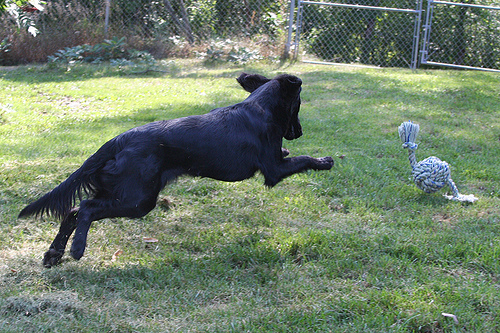

In [157]:
test_image = test_img[5]
Image.open(test_image)

In [156]:
print ('Prediction:', predict_captions(test_image)) 


Prediction: black dog is running through the grass


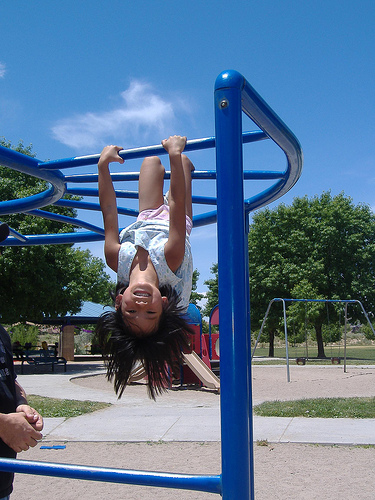

In [186]:
test_image = test_img[952]
Image.open(test_image)

In [187]:
print ('Prediction:', predict_captions(test_image)) 


Prediction: the boy is playing on the swing
